# Inverse Design of a Directional Coupler (2D) with minimax and lengthscale constraints

In [1]:
import meep as mp
print(mp.__version__)
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa, tensor_jacobian_product, grad

from matplotlib import pyplot as plt
from matplotlib.patches import Circle

import nlopt
from IPython.display import Video
from typing import NamedTuple


1.27.0


In [2]:
seed = np.random.randint(100000)
np.random.seed(seed)
mp.verbosity(0)
Si = mp.Medium(index=3.4)
SiO2 = mp.Medium(index=1.44)

minimum_length = 0.15 # (μm)
eta_e = 0.75
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length,eta_e) # (μm)

waveguide_width = 0.5 # (μm)
design_region_length = 5 + (4 * filter_radius) # (μm)
design_region_width = 1.5 + (4 * filter_radius)  # (μm)


arm_separation = 1 #design_region_width - waveguide_width - 4 * filter_radius  # (μm) distance between arms center to center
waveguide_length = 2 # (μm)
pml_size = 1.0 # (μm)
resolution = 20 # (pixels/μm)

In [3]:
#filter_radius=minimum_length

eta_i = 0.5
eta_d = 1-eta_e
design_region_resolution = int(2 * resolution) # (pixels/μm)
nf=5
frequencies = 1/np.linspace(1.5,1.6,nf) # (1/μm)

Nx = int(design_region_resolution*design_region_length)+1
Ny = int(design_region_resolution*design_region_width)+1


In [4]:
Sx = 2*pml_size + waveguide_length/2 + design_region_length+1 # cell size in X
Sy = 2*pml_size + design_region_width + 2 # cell size in Y
cell_size = mp.Vector3(Sx,Sy)

pml_layers = [mp.PML(pml_size)]

fcen = 1/1.55
width = 0.2
fwidth = width * fcen#1/1.5 - 1/1.6#width * fcen
#source_center  = [-Sx/2 + pml_size + waveguide_length/3,arm_separation/2,0]
source_size    = mp.Vector3(0,1,0)
kpoint = mp.Vector3(1,0,0)

source_center1  = [-Sx/2 + pml_size+0.2 ,arm_separation/2,0]
source_center2  = [-Sx/2 + pml_size+0.2 ,-arm_separation/2,0]


# src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
# source = [mp.EigenModeSource(src,
#                     eig_band = 1,
#                     direction=mp.NO_DIRECTION,
#                     eig_kpoint=kpoint,
#                     size = source_size,
#                     center=source_center)]

x_g = np.linspace(
    -design_region_length / 2,
    design_region_length / 2,
    Nx,
)
y_g = np.linspace(
    -design_region_width / 2,
    design_region_width / 2,
    Ny,
)
X_g, Y_g = np.meshgrid(
    x_g,
    y_g,
    sparse=True,
    indexing="ij",
)

tl_wg_mask = (X_g <= -design_region_length / 2 + filter_radius) & (
    Y_g <= (arm_separation + waveguide_width) / 2) & ( Y_g  >=(arm_separation - waveguide_width) / 2
)
                                                      
tr_wg_mask = (X_g >= design_region_length / 2 - filter_radius) & (
    Y_g <= (arm_separation + waveguide_width) / 2) & ( Y_g  >=(arm_separation - waveguide_width) / 2
)

br_wg_mask = (X_g >= design_region_length / 2 - filter_radius) & (
    Y_g <= (-arm_separation + waveguide_width) / 2) & ( Y_g  >=(-arm_separation - waveguide_width) / 2
)
                                                       
bl_wg_mask = (X_g <= -design_region_length / 2 + filter_radius) & (
    Y_g <= (-arm_separation + waveguide_width) / 2) & ( Y_g  >=(-arm_separation - waveguide_width) / 2
)                                                      
                                                     

Si_mask = tl_wg_mask | tr_wg_mask | br_wg_mask | bl_wg_mask

border_mask = (
    (X_g <= -design_region_length / 2 + filter_radius)
    | (X_g >= design_region_length / 2 - filter_radius)
    | (Y_g <= -design_region_width / 2 + filter_radius)
    | (Y_g >= design_region_width / 2 - filter_radius)
)
Air_mask = border_mask.copy()
Air_mask[Si_mask] = False


In [5]:
evaluation_history = []
cur_iter = [0]
objfunc_history=[]
epivar_history=[]

def mapping(x: np.ndarray, eta: float, beta: float) -> np.ndarray:
    """A differentiable mapping function which applies, in order,
       the following sequence of transformations to the design weights:
       (1) a bit mask for the boundary pixels, (2) convolution with a
       conic filter, and (3) projection via a hyperbolic tangent (if
       necessary).

    Args:
      x: design weights as a 1d array of size Nx*Ny.
      eta: erosion/dilation parameter for the projection.
      beta: bias parameter for the projection. A value of 0 is no projection.

    Returns:
      The mapped design weights as a 1d array.
    """
    x = npa.where(Si_mask.flatten(), 1, npa.where(Air_mask.flatten(), 0, x.flatten()))

    x = (npa.fliplr(x.reshape(Nx,Ny)) + x.reshape(Nx,Ny))/2 # up-down symmetry
    x = (npa.flipud(x.reshape(Nx,Ny)) + x.reshape(Nx,Ny))/2 # left-right symmetry

    filtered_field = mpa.conic_filter(x, filter_radius,design_region_length,design_region_width,design_region_resolution)

    if beta == 0:
        return filtered_field.flatten()

    else:
        projected_field = mpa.tanh_projection(filtered_field,beta,eta)

        return projected_field.flatten()
    




def f(x, grad):
    t = x[0]  # "dummy" parameter
    v = x[1:]  # design parameters
    if grad.size > 0:
        grad[0] = 1
        grad[1:] = 0
    return t



def c(
    result: np.ndarray, 
    x: np.ndarray, 
    gradient: np.ndarray, 
    eta: float,
    beta: float, use_epsavg: bool):
    

    """Constraint function for the epigraph formulation.

    Args:
      result: the result of the function evaluation modified in place.
      x: 1d array of size 1+Nx*Ny containing epigraph variable (first
         element) and design weights (remaining Nx*Ny elements).
      gradient: the Jacobian matrix with dimensions (1+Nx*Ny,
                2*num. wavelengths) modified in place.
      eta: erosion/dilation parameter for projection.
      beta: bias parameter for projection.
      use_epsavg: whether to use subpixel smoothing.
    """

    print(
        "Current iteration: {}; current eta: {}, current beta: {}".format(
            cur_iter[0], eta, beta
        )
    )



    t = x[0]  # epigraph variable
    v = x[1:]  # design weights

    f0, dJ_du = opt([mapping(v, eta, 0 if use_epsavg else beta)])

    # Backprop the gradients through our mapping function
    my_grad = np.zeros(dJ_du.shape)
    for k in range(opt.nf):
        my_grad[:, k] = tensor_jacobian_product(mapping, 0)(v, eta, beta, dJ_du[:, k])

    # Assign gradients
    if gradient.size > 0:
        gradient[:, 0] = -1  # gradient w.r.t. "t"
        gradient[:, 1:] = my_grad.T  # gradient w.r.t. each frequency objective

    result[:] = np.real(f0) - t

    # store results
    evaluation_history.append(np.real(f0))
    epivar_history.append(t)


    # visualize
    plt.figure()
    ax = plt.gca()
    opt.plot2D(
        False,
        ax=ax,
        plot_sources_flag=False,
        plot_monitors_flag=False,
        plot_boundaries_flag=False,
    )
    circ = Circle((2, 2), minimum_length / 2)
    ax.add_patch(circ)
    ax.axis("off")
    plt.show()

    cur_iter[0] = cur_iter[0] + 1



def glc(result: np.ndarray, x: np.ndarray, gradient: np.ndarray,
        beta: float) -> float:
    """Constraint function for the minimum linewidth.

    Args:
      result: the result of the function evaluation modified in place.
      x: 1d array of size 1+Nx*Ny containing epigraph variable (first
         element) and design weights (remaining elements).
      gradient: the Jacobian matrix with dimensions (1+Nx*Ny,
                num. wavelengths) modified in place.
      beta: bias parameter for projection.

    Returns:
      The value of the constraint function (a scalar).
    """
    t = x[0]  # dummy parameter
    v = x[1:]  # design parameters
    a1 = 1e-3  # hyper parameter (primary)
    b1 = 0  # hyper parameter (secondary)
    gradient[:, 0] = -a1

    filter_f = lambda a: mpa.conic_filter(
        a.reshape(Nx, Ny),
        filter_radius,
        design_region_length,
        design_region_width,
        design_region_resolution,
    )
    threshold_f = lambda a: mpa.tanh_projection(a, beta, eta_i)

    # hyper parameter (constant factor and exponent)
    c0 = 1e7 * (filter_radius * 1 / resolution) ** 4

    M1 = lambda a: mpa.constraint_solid(a, c0, eta_e, filter_f, threshold_f, 1)
    M2 = lambda a: mpa.constraint_void(a, c0, eta_d, filter_f, threshold_f, 1)

    g1 = grad(M1)(v)
    g2 = grad(M2)(v)

    result[0] = M1(v) - a1 * t - b1
    result[1] = M2(v) - a1 * t - b1

    gradient[0, 1:] = g1.flatten()
    gradient[1, 1:] = g2.flatten()

    t1 = (M1(v) - b1) / a1
    t2 = (M2(v) - b1) / a1

    print(f"glc:, {result[0]}, {result[1]}, {t1}, {t2}")

    return max(t1, t2)





def straight_waveguide() -> (np.ndarray, NamedTuple):
    """Computes the DFT fields from the mode source in a straight waveguide
       for use as normalization of the reflectance measurement during the
       optimization.

    Returns:
      A 2-tuple consisting of a 1d array of DFT fields and DFT fields object
      returned by `meep.get_flux_data`.
    """

 

    Sx = 2*pml_size + 3 +1 # cell size in X
    Sy = 2*pml_size + 4*waveguide_width  # cell size in Y

    refl_pt =mp.Vector3(Sx/2 - pml_size-0.1)
    stop_cond = mp.stop_when_fields_decayed(50, mp.Ez, refl_pt, 1e-8)

    cell_size = mp.Vector3(Sx,Sy)

    sources = [
        mp.EigenModeSource(
            src=mp.GaussianSource(fcen, fwidth=fwidth),
            size=source_size,
            center=mp.Vector3(x= -Sx/2 + pml_size + 0.1),
            eig_band=1,
        )
    ]

    geometry = [
        mp.Block(
            size=mp.Vector3(mp.inf, waveguide_width),
            center=mp.Vector3(),
            material=Si,
        )
    ]

    sim = mp.Simulation(
        resolution=resolution,
        default_material=mp.air,
        cell_size=cell_size,
        sources=sources,
        geometry=geometry,
        boundary_layers=pml_layers,
        k_point=mp.Vector3(),
    )

    refl_mon = sim.add_mode_monitor(
        frequencies,
        mp.ModeRegion(center= refl_pt, size=source_size),
        yee_grid=True,
    )

    sim.run(until_after_sources=stop_cond)

    res = sim.get_eigenmode_coefficients(
        refl_mon,
        [1],
    )

    coeffs = res.alpha
    input_flux = np.abs(coeffs[0, :, 0]) ** 2
    input_flux_data = sim.get_flux_data(refl_mon)

    return input_flux, input_flux_data


def dc_optimization(
        input_flux: np.ndarray,
        input_flux_data: NamedTuple,
        use_damping: bool = False,
        use_epsavg: bool = False,
        beta: float = 0) -> mpa.OptimizationProblem:
    """Sets up the adjoint optimization of the waveguide mode converter.

    Args:
      use_damping: whether to use the damping feature of `MaterialGrid`.
      use_epsavg: whether to use subpixel smoothing in `MaterialGrid`.

    Returns:
      A `meep.adjoint.OptimizationProblem` class object.
    """

    design_variables = mp.MaterialGrid(
        mp.Vector3(Nx,Ny),
        mp.air,
        Si,
        weights=np.ones((Nx, Ny)),
        beta=beta if use_epsavg else 0,
        do_averaging = True if use_epsavg else False,
        damping=0.02 * 2 * np.pi * fcen if use_damping else 0,
    )

    design_region = mpa.DesignRegion(
        design_variables,
        volume=mp.Volume(
            center=mp.Vector3(), 
            size=mp.Vector3(design_region_length, design_region_width),
            ),
        )



    geometry = [
        mp.Block(center=mp.Vector3(x=-(design_region_length+waveguide_length)/2, y=arm_separation/2), material=Si, size=mp.Vector3(waveguide_length, waveguide_width, 0)), # top left waveguide
        mp.Block(center=mp.Vector3(x=-(design_region_length+waveguide_length)/2, y=-arm_separation/2), material=Si, size=mp.Vector3(waveguide_length, waveguide_width, 0)), # bottom left waveguide
        mp.Block(center=mp.Vector3(x=(design_region_length+waveguide_length)/2, y=arm_separation/2), material=Si, size=mp.Vector3(waveguide_length, waveguide_width, 0)), # top right waveguide
        mp.Block(center=mp.Vector3(x=(design_region_length+waveguide_length)/2, y=-arm_separation/2), material=Si, size=mp.Vector3(waveguide_length, waveguide_width, 0)), # bottom right waveguide
        mp.Block(center=design_region.center, size=design_region.size, material=design_variables)
    ]



    src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
    sources = [mp.EigenModeSource(src,
                        eig_band = 1,
                        direction=mp.NO_DIRECTION,
                        eig_kpoint=kpoint,
                        size = source_size,
                        center=source_center1,
                        amplitude=1.0),
                mp.EigenModeSource(
                        src,
                        eig_band=1,
                        direction=mp.NO_DIRECTION,
                        eig_kpoint=kpoint,
                        size=source_size,
                        center=source_center2,
                        amplitude=0.0 - 1.0j
        )]



    sim = mp.Simulation(cell_size=cell_size,
                        boundary_layers=pml_layers,
                        geometry=geometry,
                        sources=sources,
                        #symmetries=[mp.Mirror(direction=mp.Y)],
                        default_material=mp.air,
                        resolution=resolution)



    mode = 1

    TE0 = mpa.EigenmodeCoefficient(sim,
            mp.Volume(center=mp.Vector3(x=Sx/2 - pml_size - 0.4, y=arm_separation/2),
                size=source_size),mode,)
    # TE_top = mpa.EigenmodeCoefficient(sim,
    #         mp.Volume(center=mp.Vector3(-Sx/2 + pml_size + 0.4,arm_separation/2,0),
    #             size=source_size),mode, forward=False, subtracted_dft_fields=input_flux_data,)
    # TE_bottom = mpa.EigenmodeCoefficient(sim,
    #         mp.Volume(center=mp.Vector3(-Sx/2 + pml_size + 0.4,-arm_separation/2,0),
    #             size=source_size),mode, forward=False,  subtracted_dft_fields=input_flux_data,)
    
    ob_list = [TE0] #[TE0,TE_top,TE_bottom]


    # def J_ref_top(output,top_monitor,bottom_monitor):
    #     power = npa.abs(top_monitor) ** 2 / input_flux
    #     return power

    # def J_ref_bot(output,top_monitor,bottom_monitor):
    #     power = npa.abs(bottom_monitor) ** 2 / input_flux
    #     return power 

    def J_trans(output):
        power = npa.abs(output) ** 2 / (2 * input_flux) 
        return 1-power

    opt = mpa.OptimizationProblem(
        simulation = sim,
        objective_functions = [J_trans ],#, J_ref_top, J_ref_bot], # i dont think the order matters here its just the list of objective functions
        objective_arguments = ob_list,
        design_regions = [design_region],
        frequencies=frequencies
    )
    return opt




In [6]:
Nx,Ny

(225, 85)

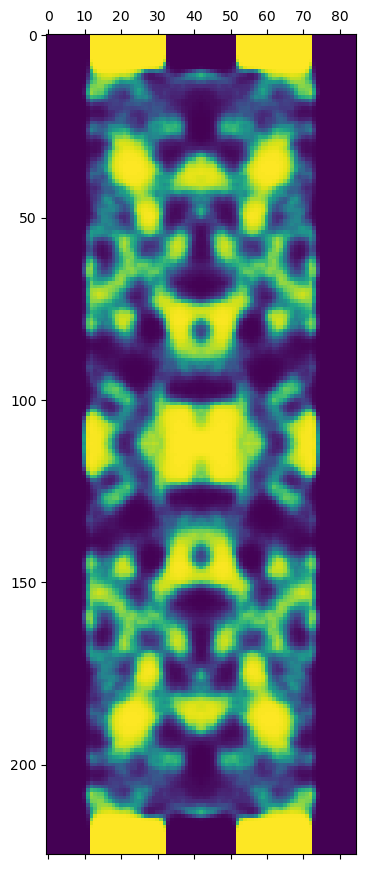

In [7]:
plt.matshow(mapping(np.random.rand(Nx,Ny),0.5,64).reshape(Nx,Ny))

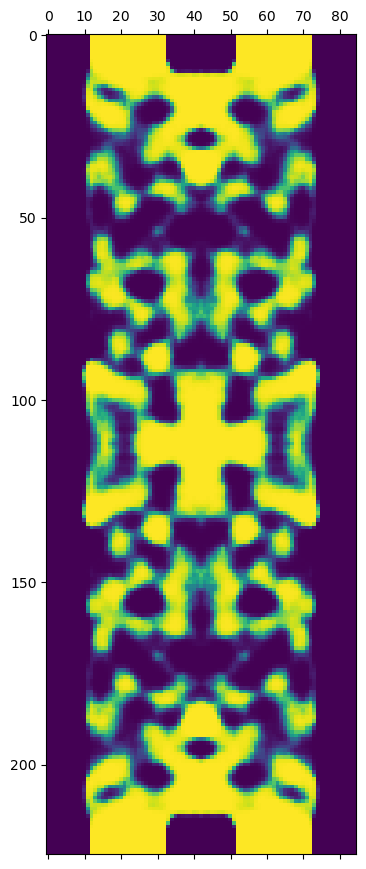

In [8]:
plt.matshow(mapping(np.random.rand(Nx,Ny),0.5,128).reshape(Nx,Ny))

In [9]:
input_flux, input_flux_data = straight_waveguide()

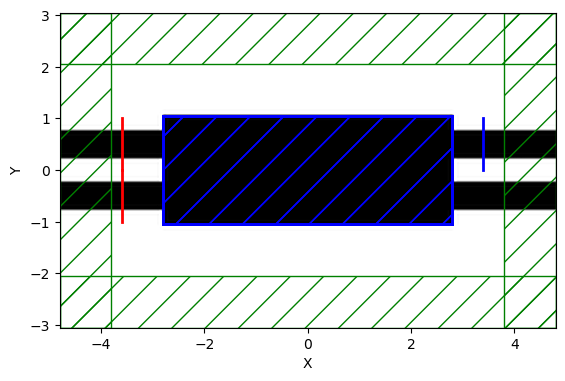

In [10]:
op=dc_optimization(input_flux,input_flux_data, beta=64)
op.plot2D(True)

## Gradient visualization

In [11]:
# x0 = 0.5*np.ones((Nx,Ny)) #+ np.random.normal(loc=mean, scale=std, size=(Nx,Ny))

# #just for the same of a boundary value
# x0=np.where(x0>1,1,x0)
# x0=np.where(x0<0,0,x0)

# #x0 = np.random.rand(Nx,Ny)
# f0, g0 = op([mapping(x0,0.5,2)])

In [12]:
# np.shape(g0.T)

In [13]:
# plt.figure()
# print(g0.shape)
# plt.imshow(np.rot90(g0[:,0].reshape(Nx,Ny)))
# plt.colorbar()

In [14]:
# backprop_gradient = tensor_jacobian_product(mapping,0)(x0,0.5,2,g0[:,0])
# plt.imshow(np.rot90(backprop_gradient.reshape(Nx,Ny)))
# plt.colorbar()

## For the phase, 2 things must be considered: 
1. The top input and top output are inphase
2. The top input and top output had a phase difference of pi/2 with the bottom waveguide

That's why we use "Phase injected topology optimization" ( Read more here: https://pubs.acs.org/doi/abs/10.1021/acsphotonics.2c01016)

Starting forward run...
Current iteration: 0; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


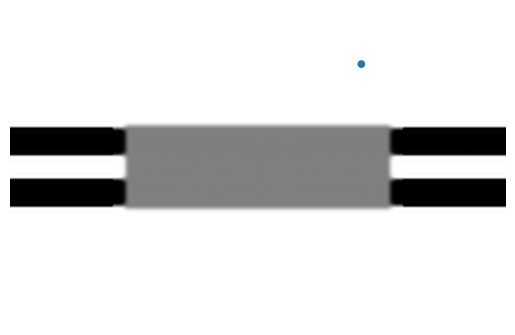

Current iteration: 1; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


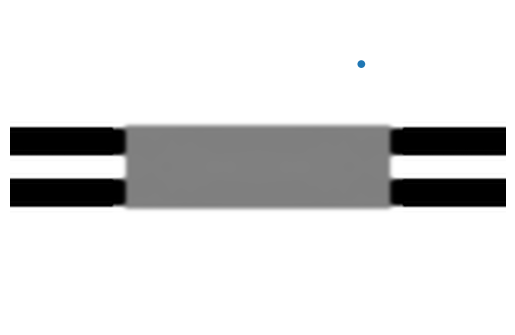

Current iteration: 2; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


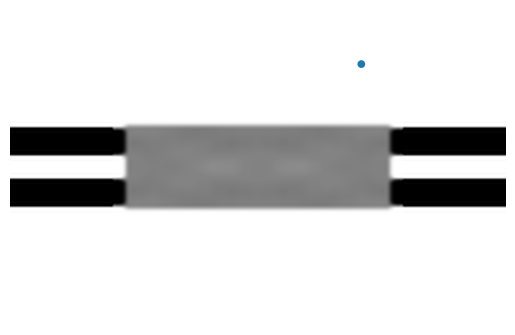

Current iteration: 3; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


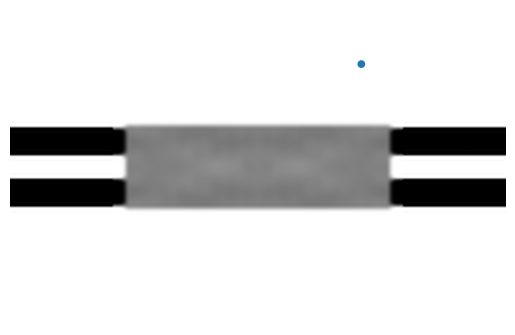

Current iteration: 4; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


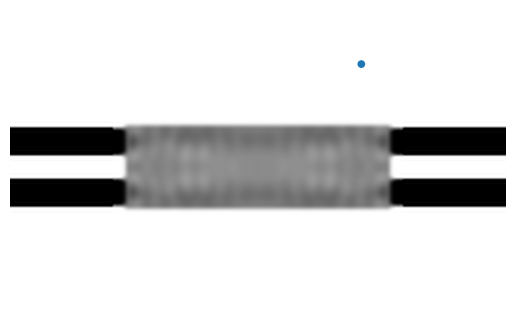

Current iteration: 5; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


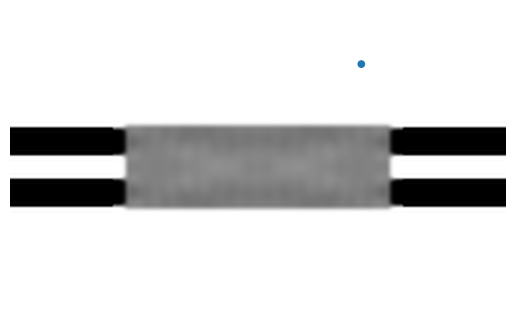

Current iteration: 6; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


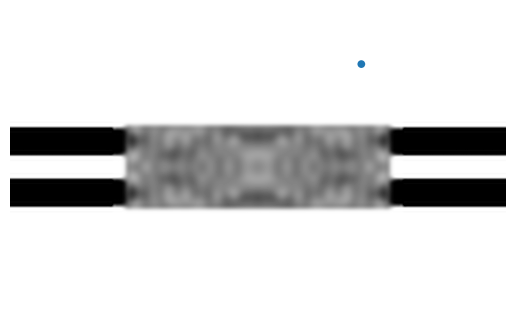

Current iteration: 7; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


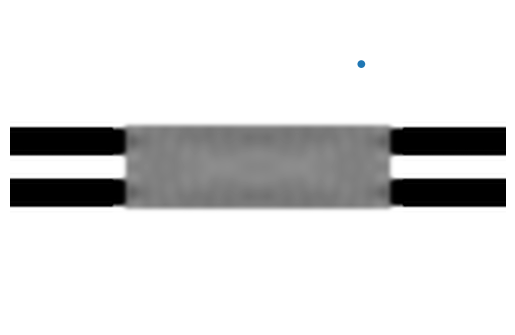

Current iteration: 8; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


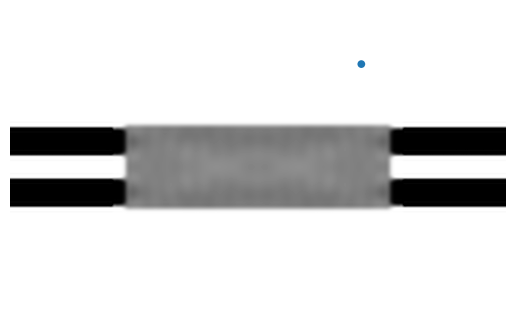

Current iteration: 9; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


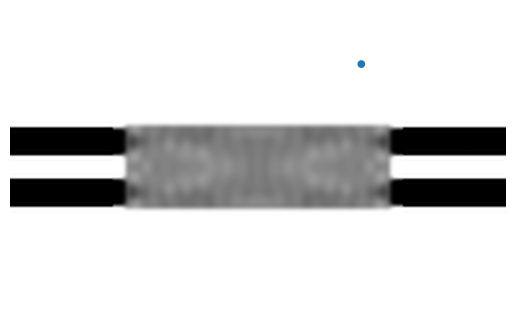

Current iteration: 10; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


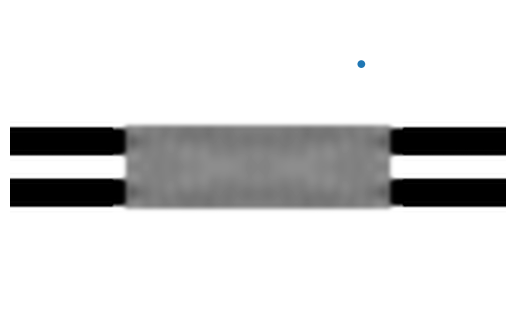

Current iteration: 11; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


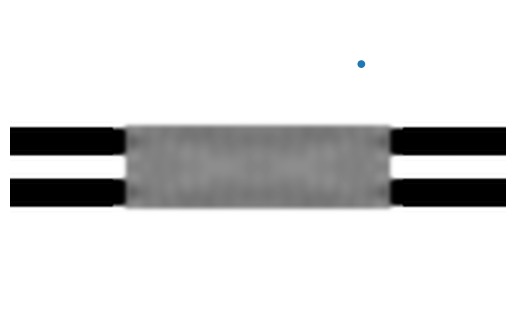

Current iteration: 12; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


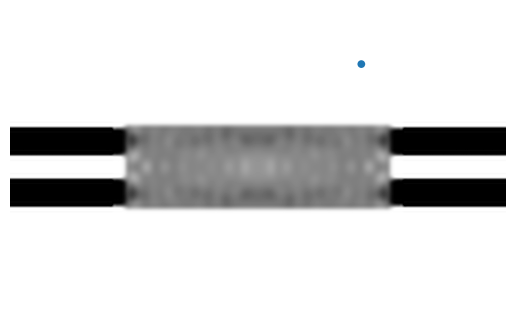

Current iteration: 13; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


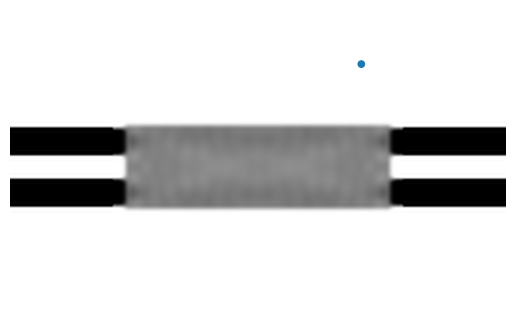

Current iteration: 14; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


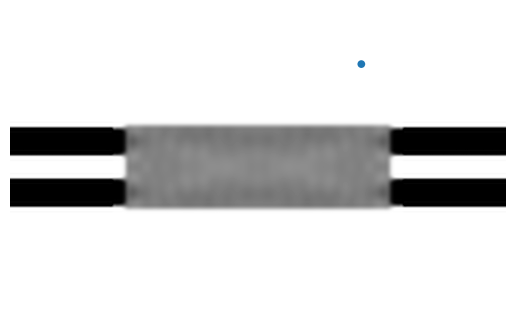

Current iteration: 15; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


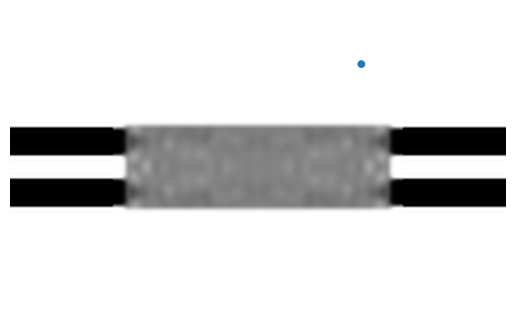

Current iteration: 16; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


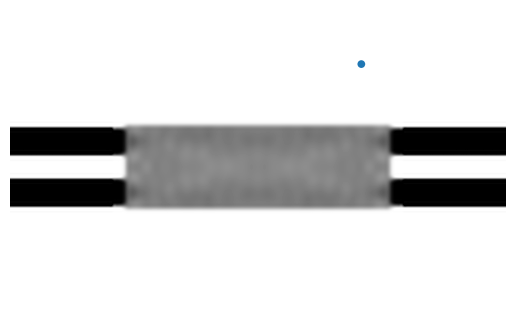

Current iteration: 17; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


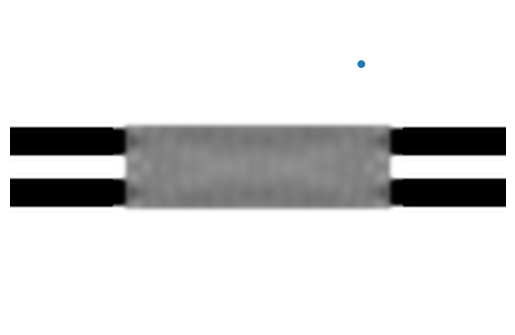

Current iteration: 18; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


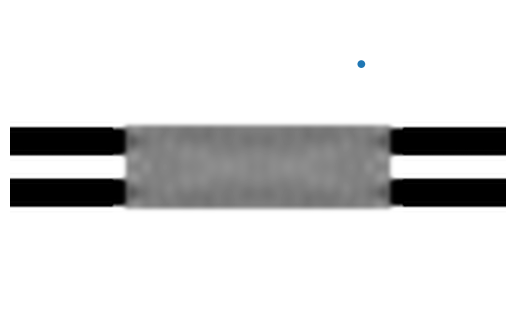

Current iteration: 19; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


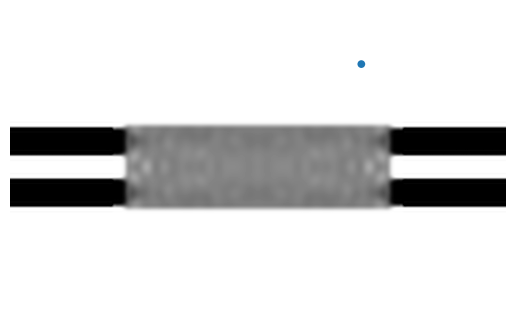

Current iteration: 20; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


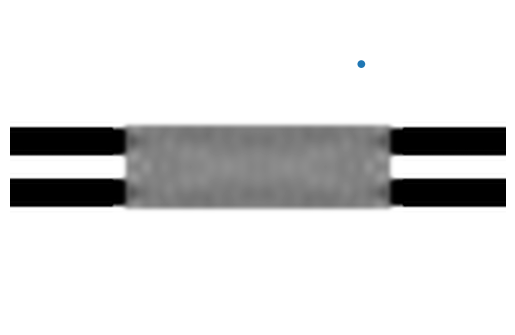

Current iteration: 21; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


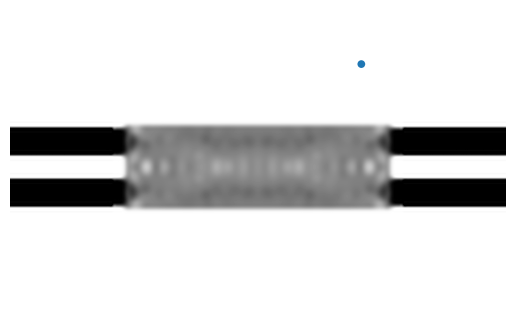

Current iteration: 22; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


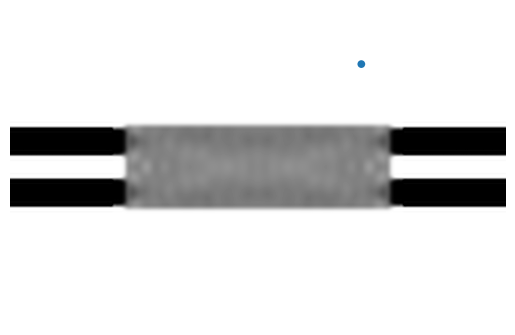

Current iteration: 23; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


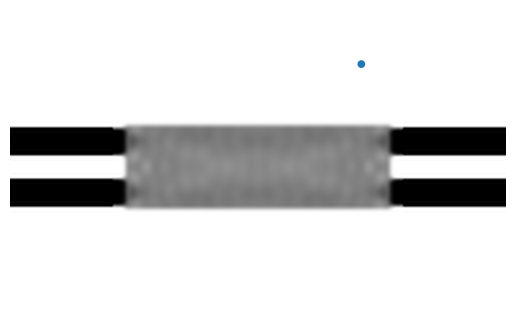

Current iteration: 24; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


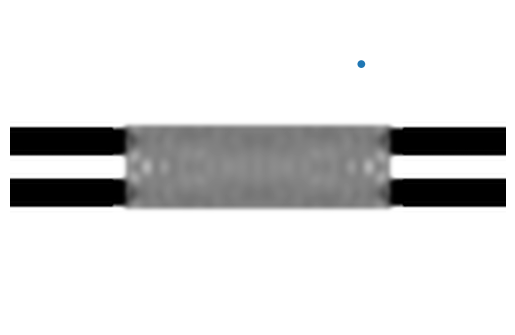

Current iteration: 25; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


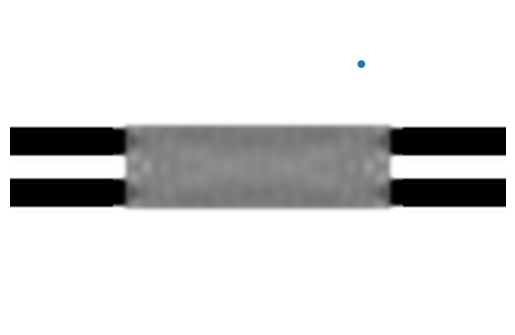

Current iteration: 26; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


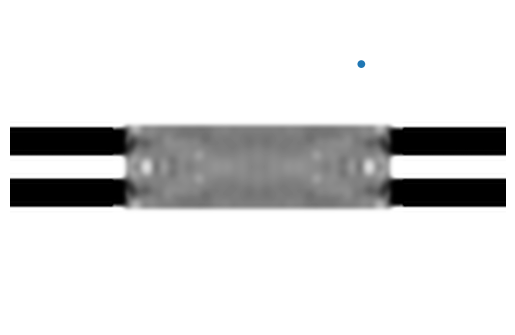

Current iteration: 27; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


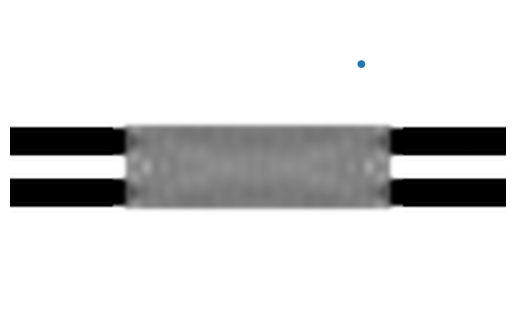

Current iteration: 28; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


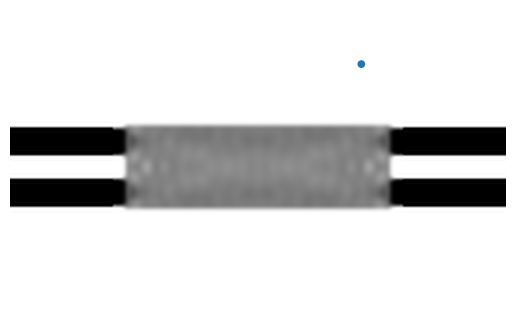

Current iteration: 29; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


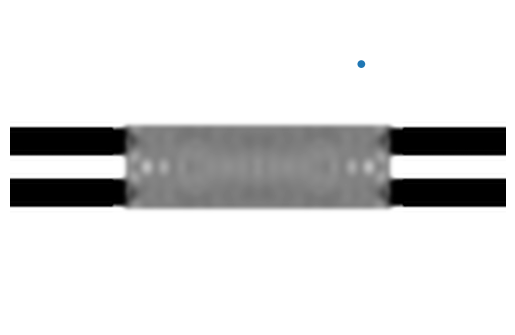

Current iteration: 30; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


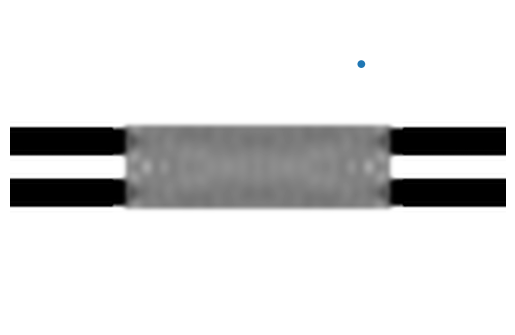

Current iteration: 31; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


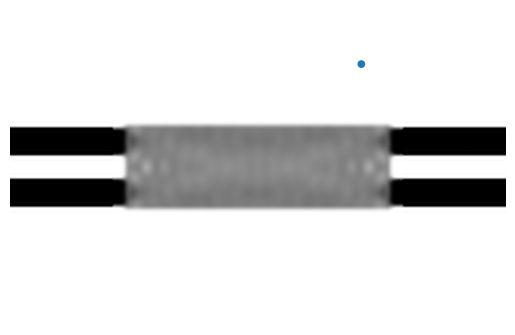

Current iteration: 32; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


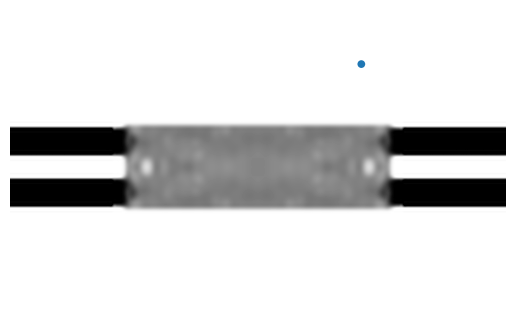

Current iteration: 33; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


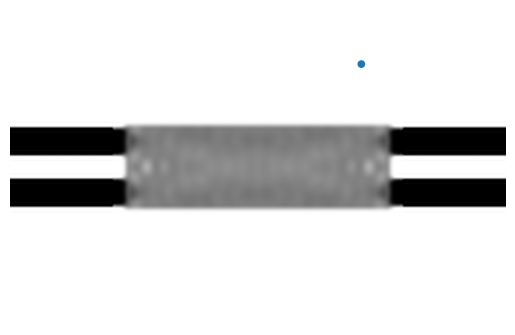

Current iteration: 34; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


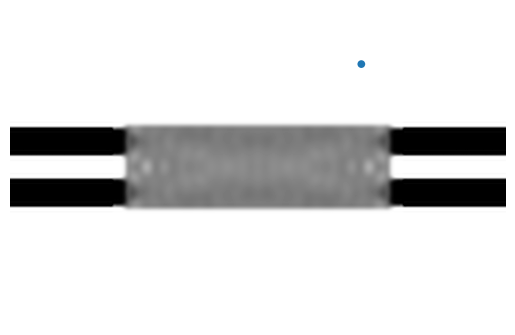

Current iteration: 35; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


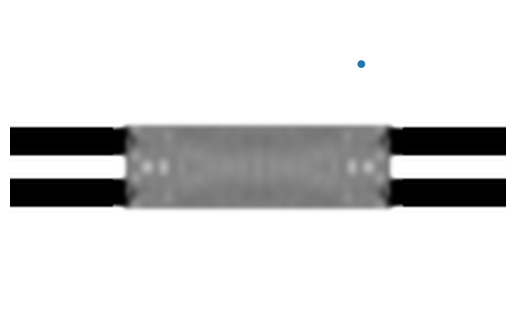

Current iteration: 36; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


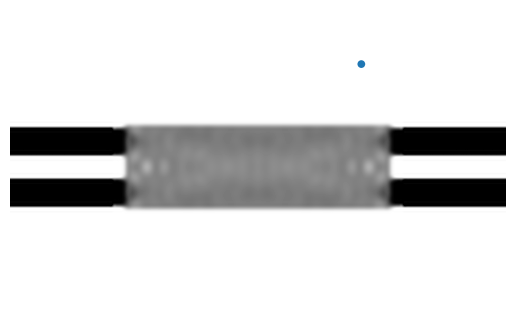

Current iteration: 37; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


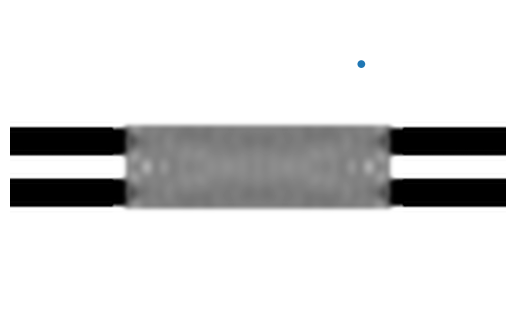

Current iteration: 38; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


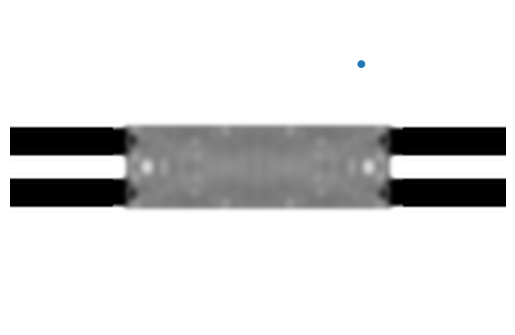

Current iteration: 39; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


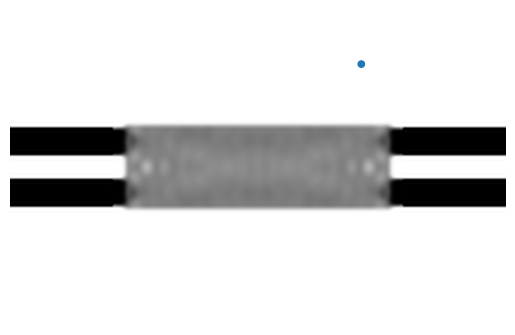

Current iteration: 40; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


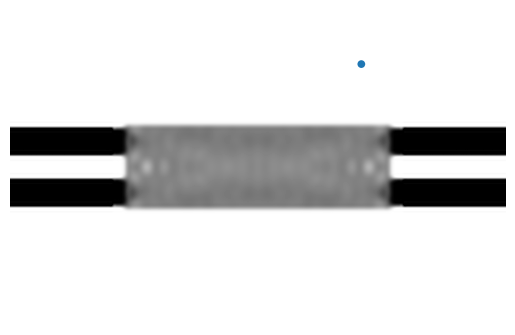

Current iteration: 41; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


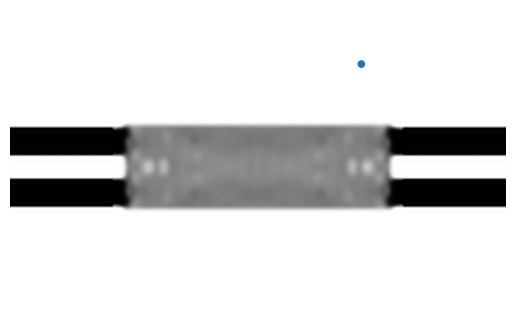

Current iteration: 42; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


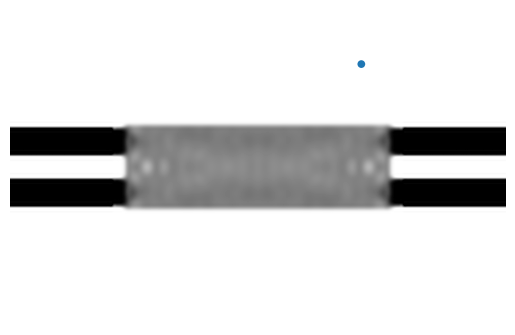

Current iteration: 43; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


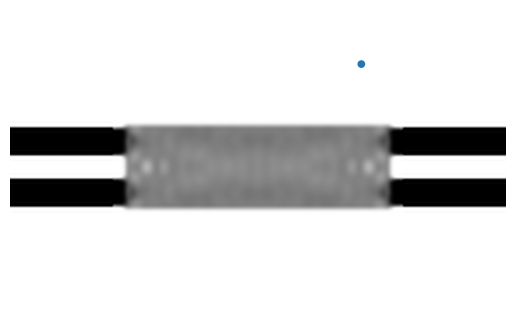

Current iteration: 44; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


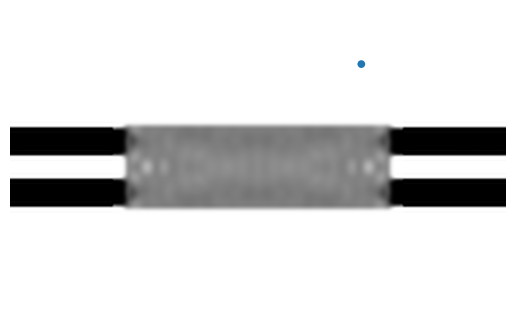

Current iteration: 45; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


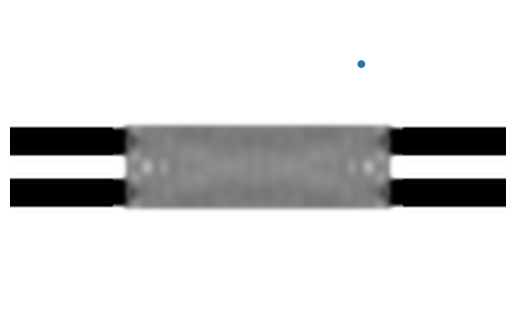

Current iteration: 46; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


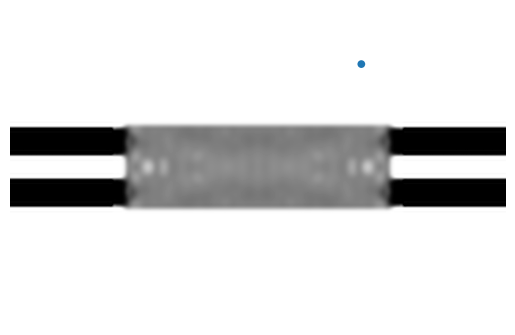

Current iteration: 47; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


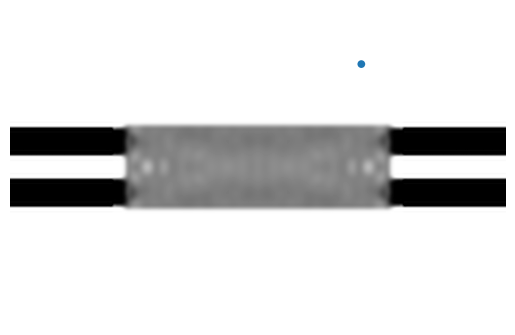

Current iteration: 48; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


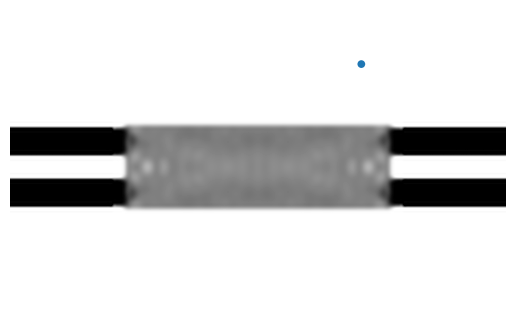

Current iteration: 49; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


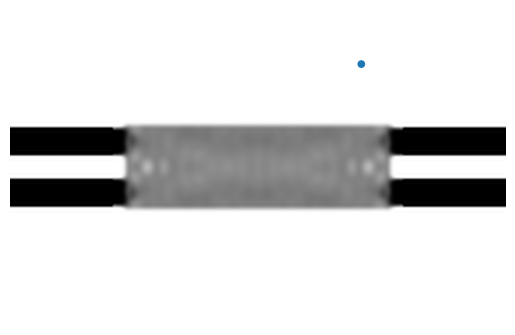

/home/satadrudas/anaconda3/envs/meep/lib/python3.11/site-packages/meep/geom.py:582: UserWarning: The weights parameter of MaterialGrid must be in the range [0,1].
  warnings.warn(


Starting forward run...
Current iteration: 50; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


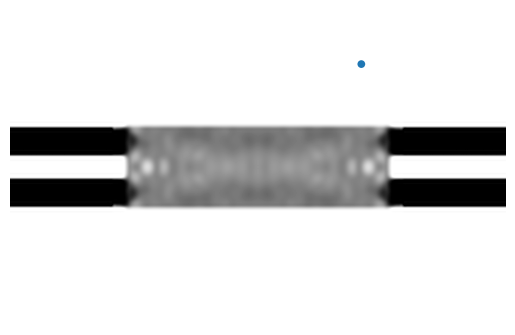

Current iteration: 51; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


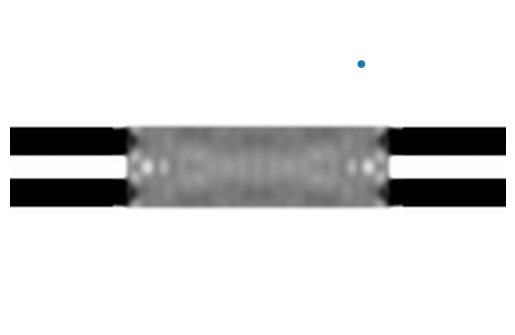

Current iteration: 52; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


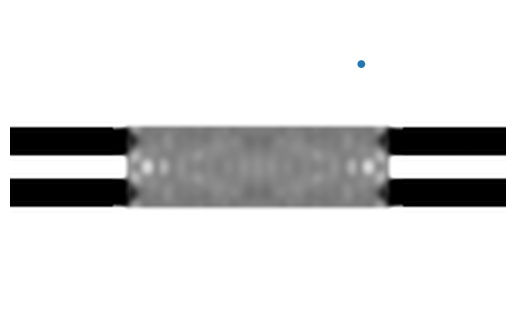

Current iteration: 53; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


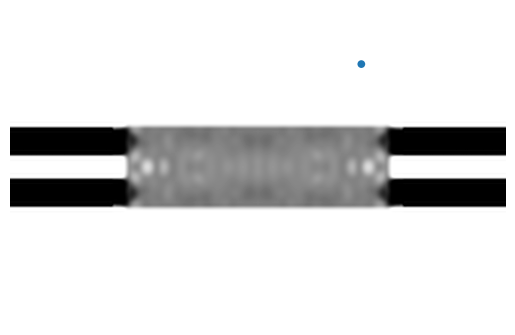

Current iteration: 54; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


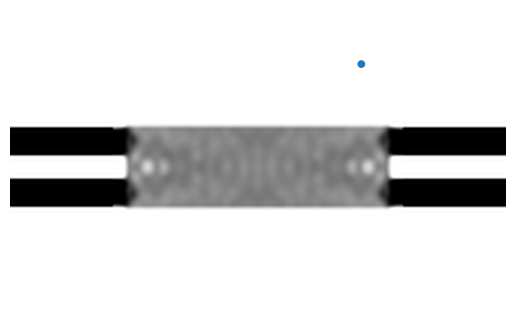

Current iteration: 55; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


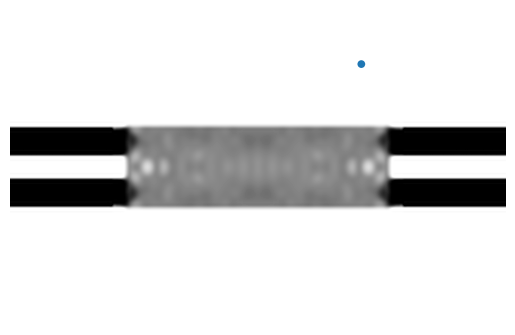

Current iteration: 56; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


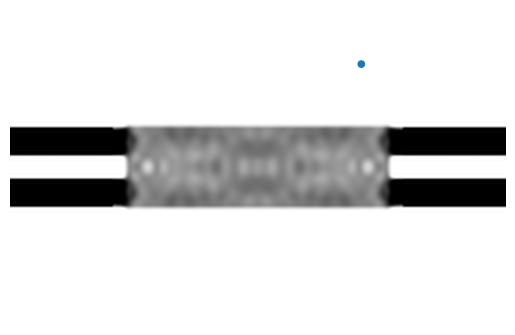

Current iteration: 57; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


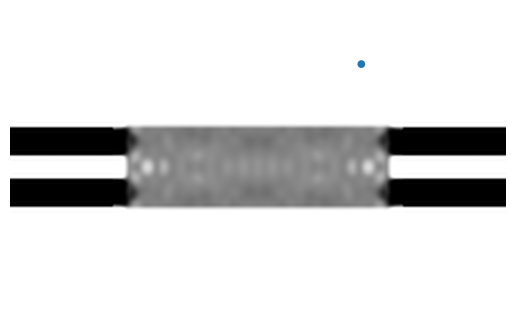

Current iteration: 58; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


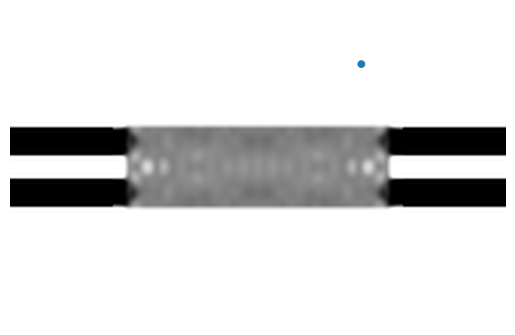

Current iteration: 59; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


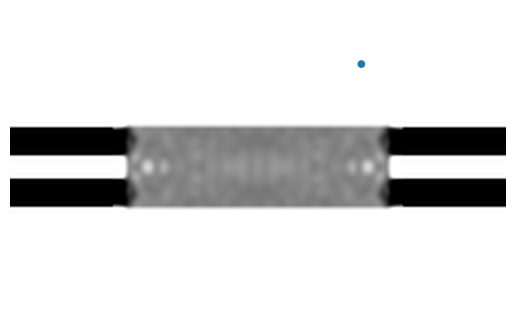

Current iteration: 60; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


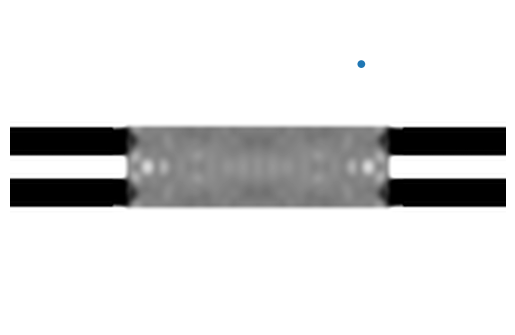

Current iteration: 61; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


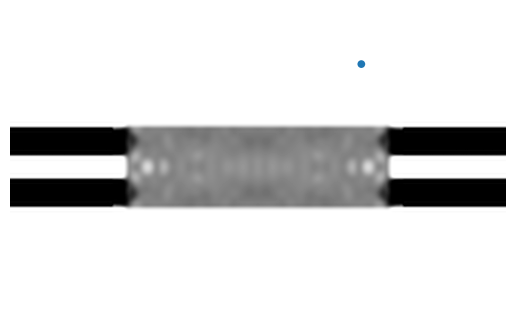

Current iteration: 62; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


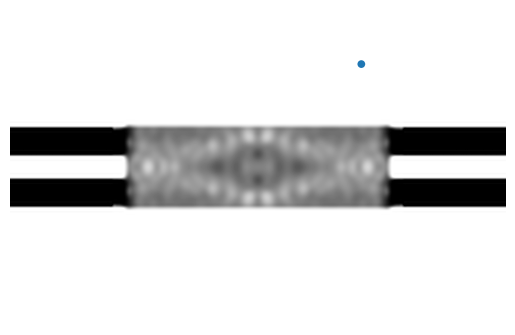

Current iteration: 63; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


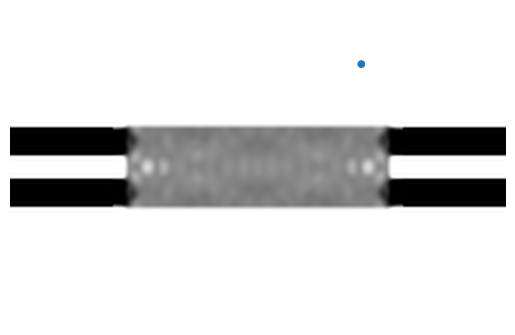

Current iteration: 64; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


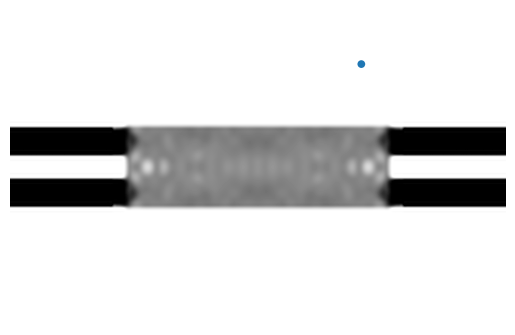

Current iteration: 65; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


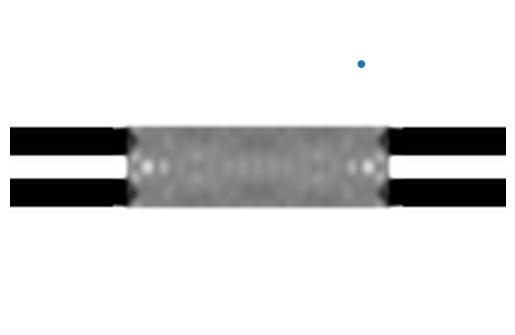

Current iteration: 66; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


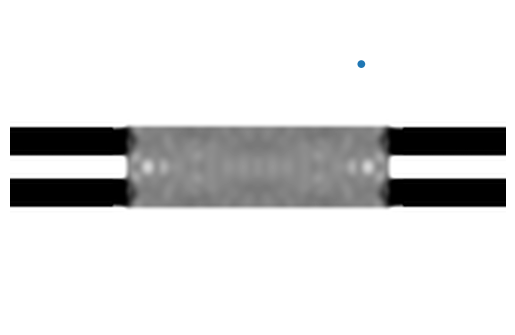

Current iteration: 67; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


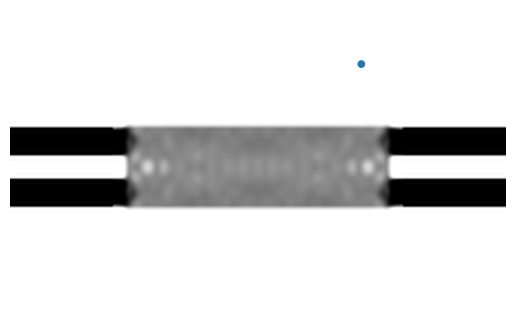

Current iteration: 68; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


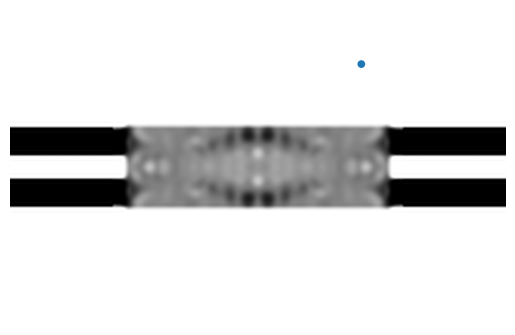

Current iteration: 69; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


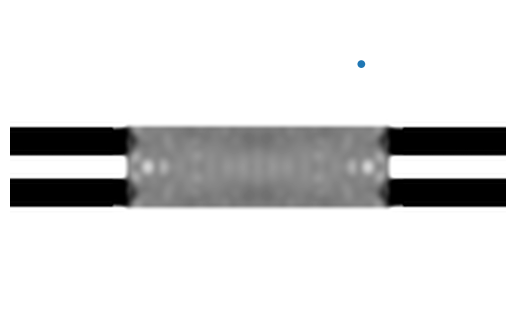

Current iteration: 70; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


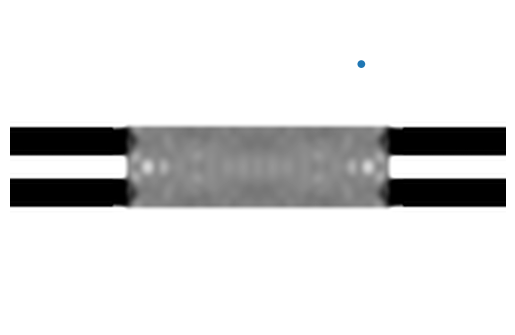

Current iteration: 71; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


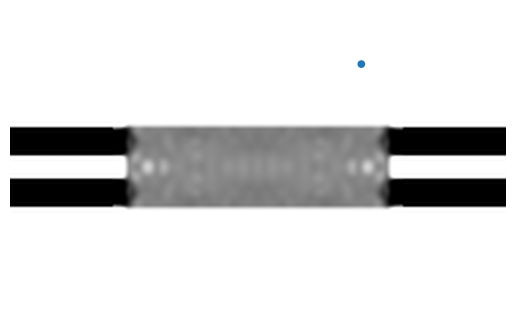

Current iteration: 72; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


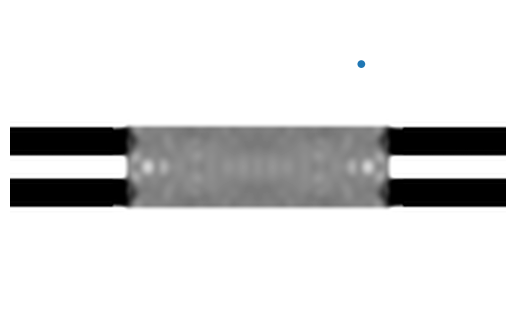

Current iteration: 73; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


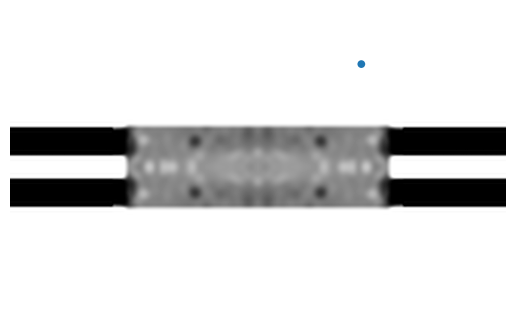

Current iteration: 74; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


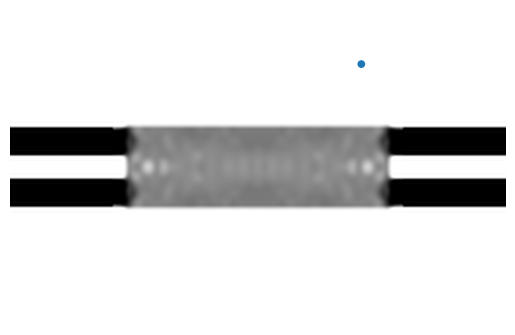

Current iteration: 75; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


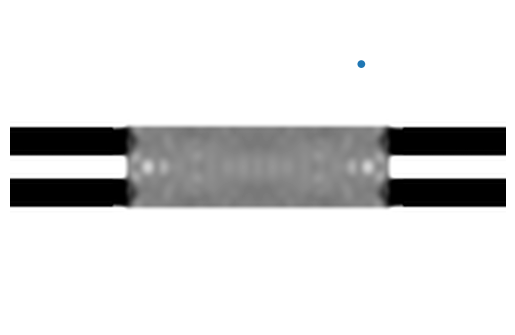

Current iteration: 76; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


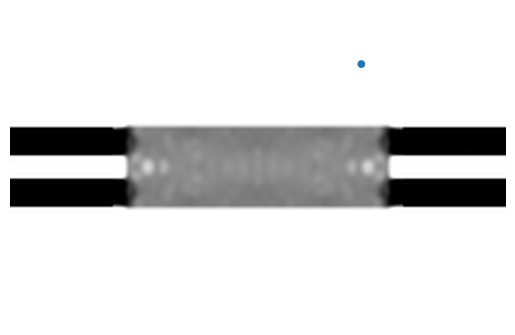

Current iteration: 77; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


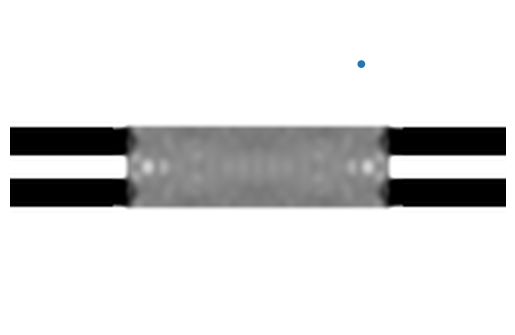

Current iteration: 78; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


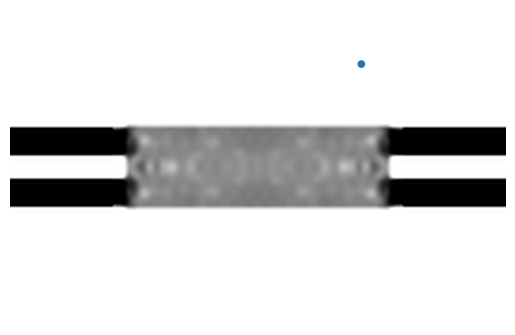

Current iteration: 79; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


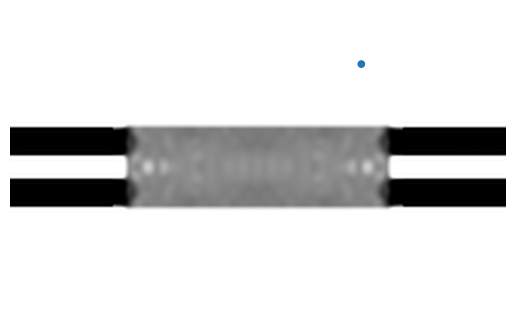

Current iteration: 80; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


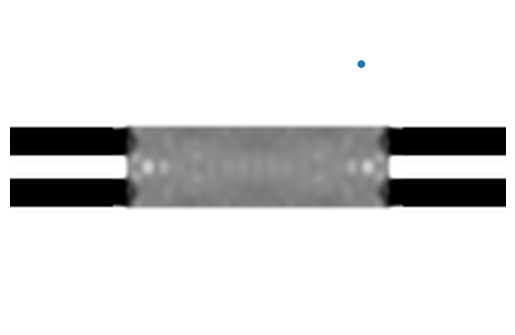

Current iteration: 81; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


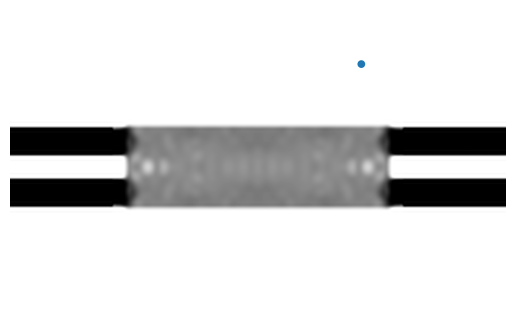

Current iteration: 82; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


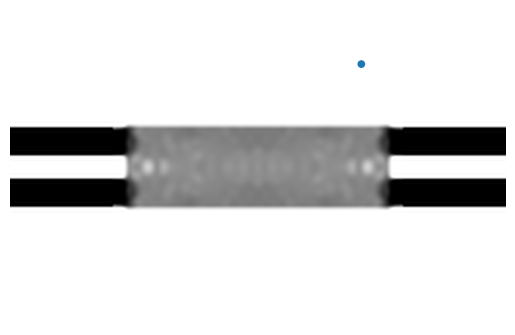

Current iteration: 83; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


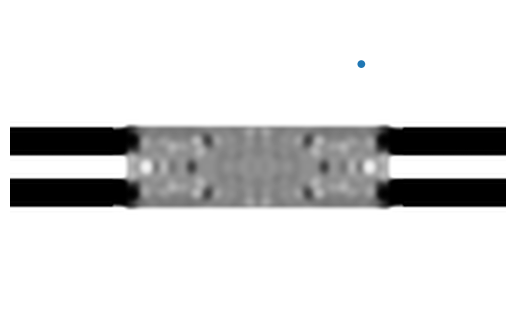

Current iteration: 84; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


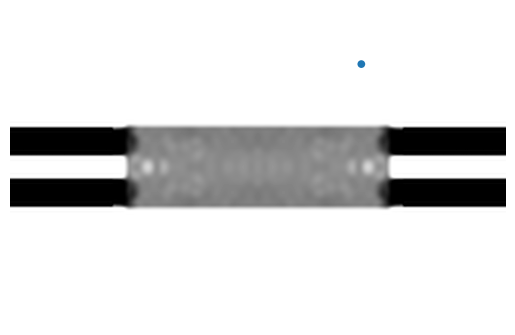

Current iteration: 85; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


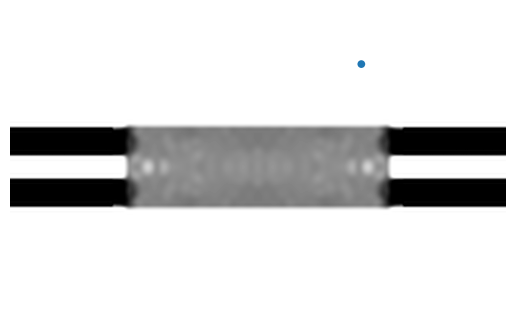

Current iteration: 86; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


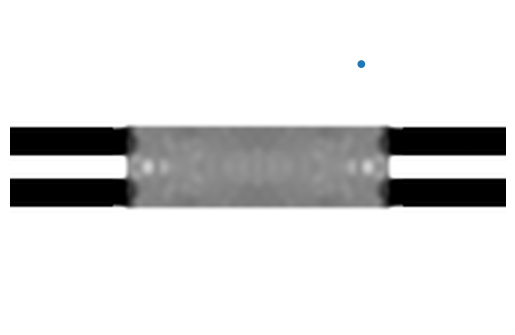

Current iteration: 87; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


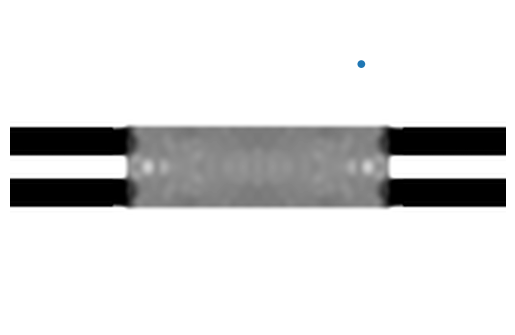

Current iteration: 88; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


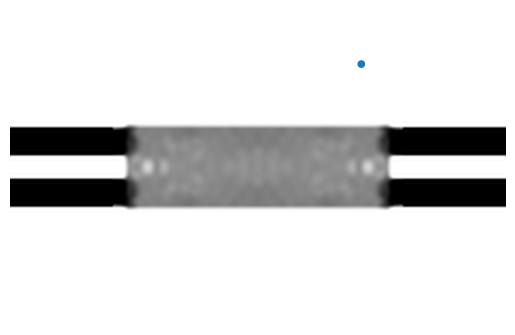

Current iteration: 89; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


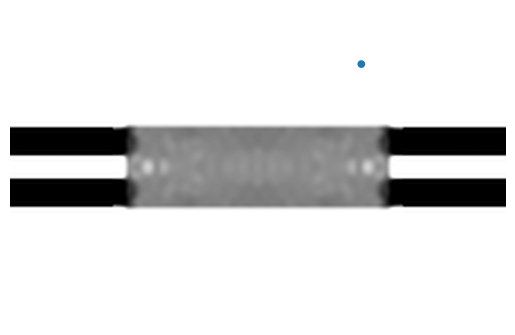

Current iteration: 90; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


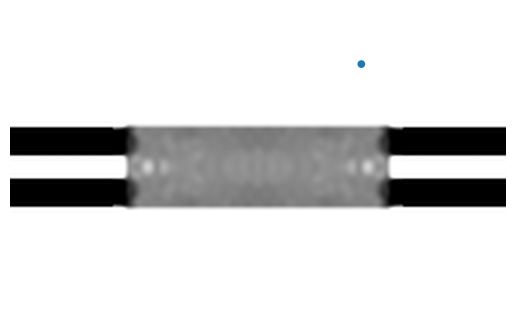

Current iteration: 91; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


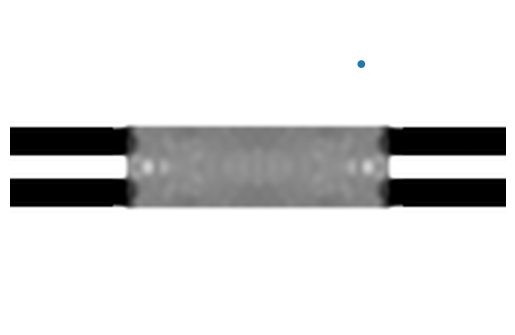

Current iteration: 92; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


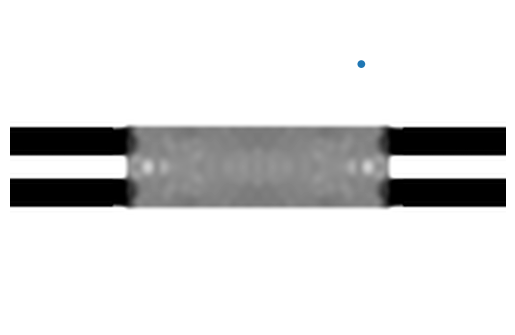

Current iteration: 93; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


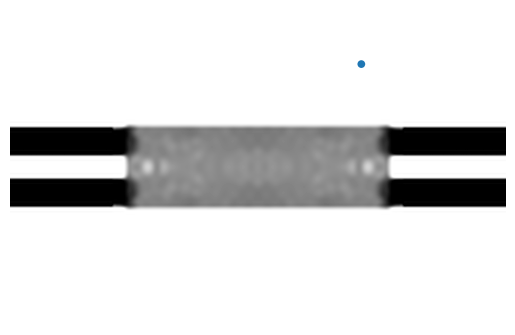

Current iteration: 94; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


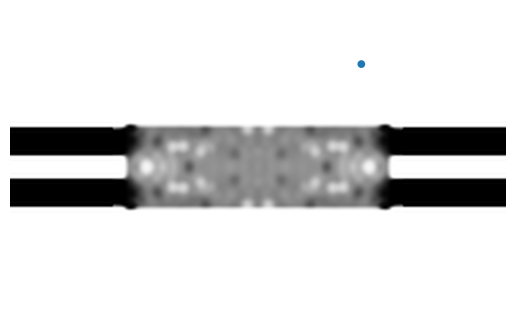

Current iteration: 95; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


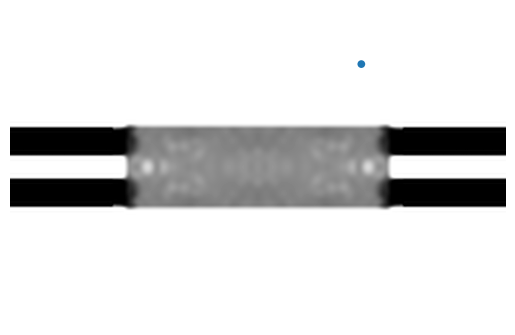

Current iteration: 96; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


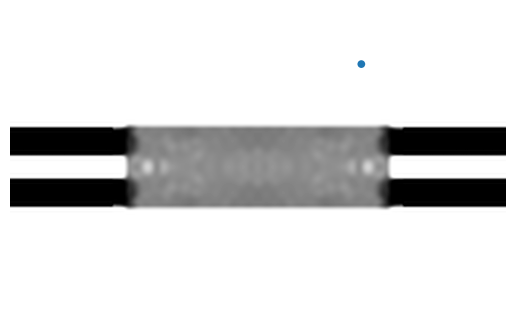

Current iteration: 97; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


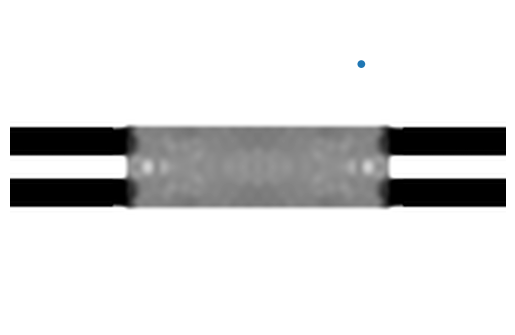

Current iteration: 98; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


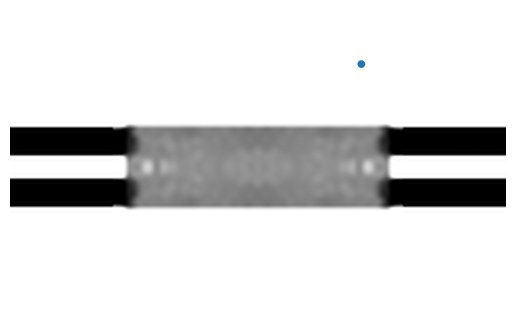

Current iteration: 99; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


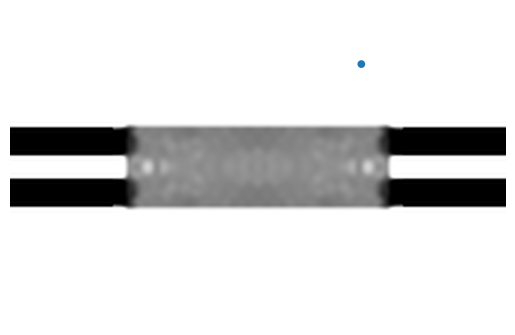

glc:, 0.019494332018804343, 0.02403864233136716, 19.730355431084927, 24.27466574364774
Starting forward run...
Current iteration: 100; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


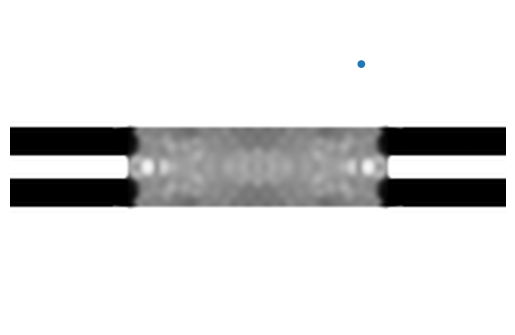

glc:, -0.005758043599745206, -0.0012137332871823905, 19.730355431084927, 24.27466574364774
Current iteration: 101; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


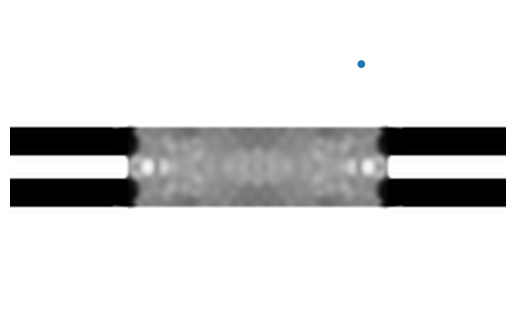

glc:, -0.0057061134692836905, -0.0011687497006989192, 19.734076035946753, 24.27143980453152
Current iteration: 102; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


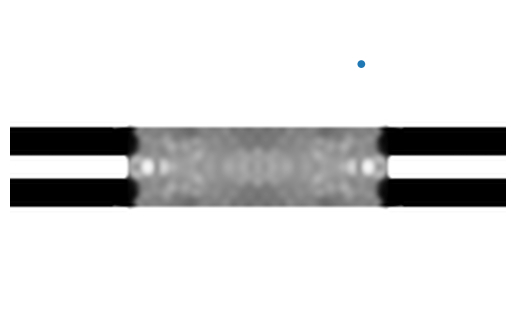

glc:, -0.005526149648656539, -0.0010607290078126705, 19.772577678056248, 24.237998318900118
Current iteration: 103; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


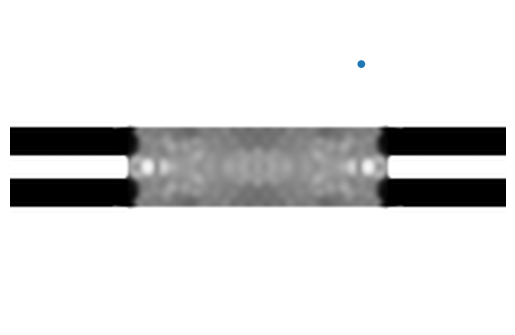

glc:, -0.004417919955151554, -0.0009917414177407179, 20.322373075835653, 23.74855161324649
Current iteration: 104; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


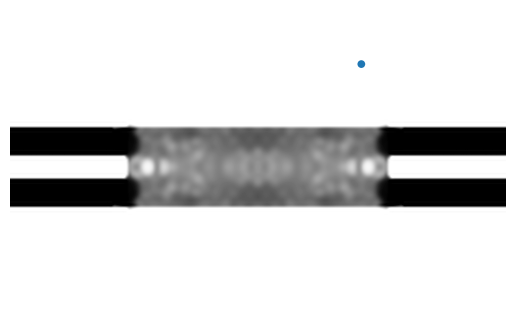

glc:, -0.0019332825878642206, -0.001898698439999371, 21.939132579063546, 21.973716726928398
Current iteration: 105; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


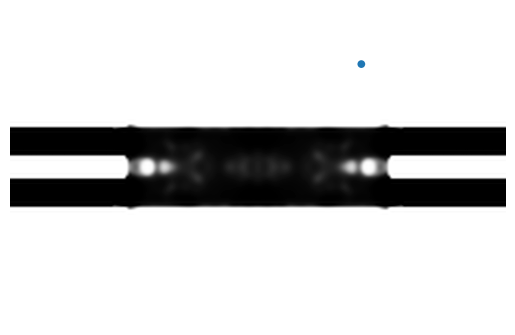

glc:, 0.0019802138539269723, -0.016034287207069065, 24.774090778048897, 6.759589717052862
Current iteration: 106; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


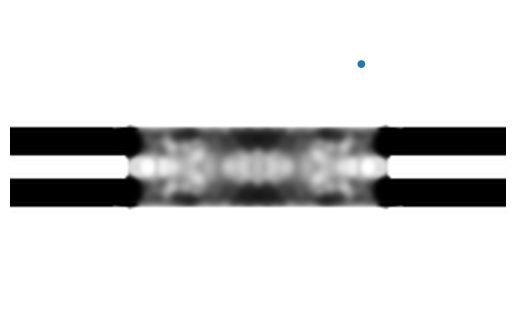

glc:, -0.002375616430226598, -0.00221821116100401, 20.485287203180746, 20.642692472403336
Current iteration: 107; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


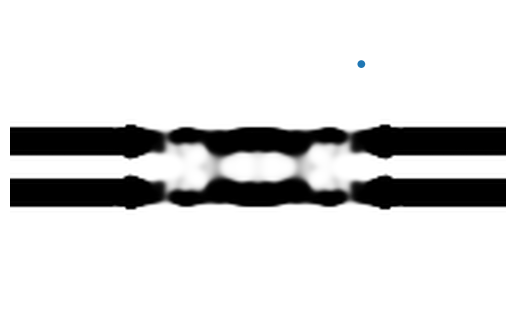

glc:, -0.011620626040005485, -0.009595638276008919, 10.024709197103872, 12.04969696110044
Current iteration: 108; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


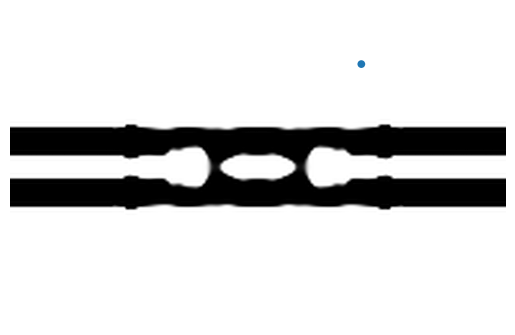

glc:, -0.014481601590850969, -0.014492599279685523, 5.306323972071384, 5.29532628323683
Current iteration: 109; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


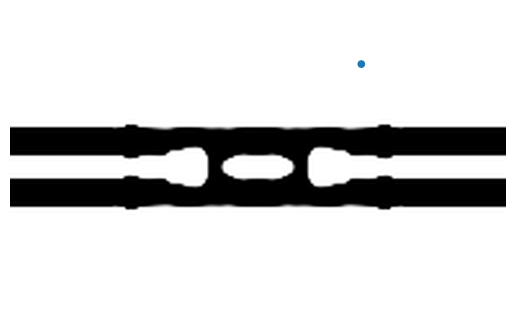

glc:, -0.013512821555379728, -0.01408118741063705, 4.417284544769638, 3.848918689512316
Current iteration: 110; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


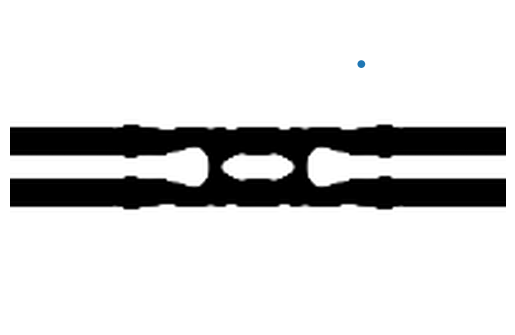

glc:, -0.012333295961163657, -0.012871574367081225, 3.4011348029054154, 2.8628563969878478
Current iteration: 111; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


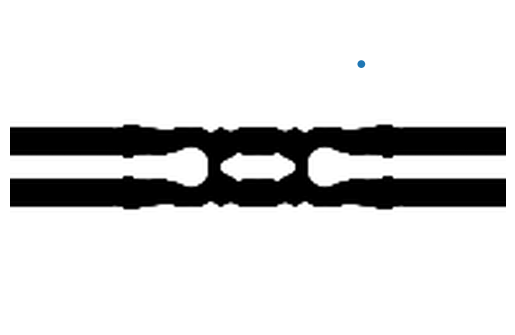

glc:, -0.010002731271707772, -0.01062207400518399, 3.2094243368625546, 2.5900816033863356
Current iteration: 112; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


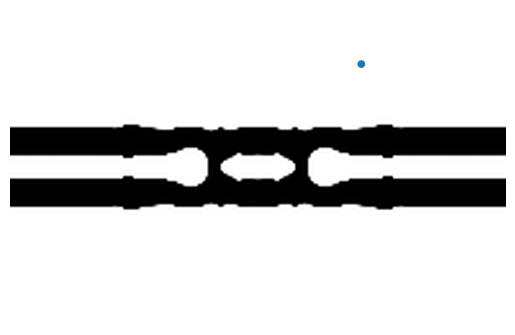

glc:, -0.008063139780698551, -0.008231019331498387, 2.4509314392025905, 2.2830518884027544
Current iteration: 113; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


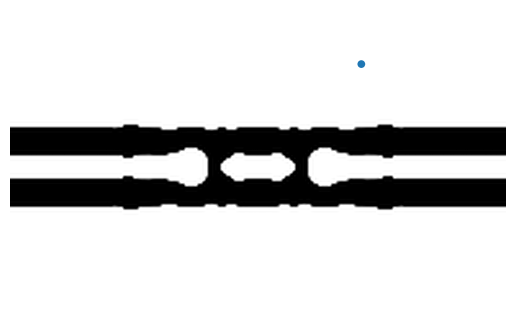

glc:, -0.0049901633102787096, -0.005141732001354976, 2.4164904205961633, 2.264921729519897
Current iteration: 114; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


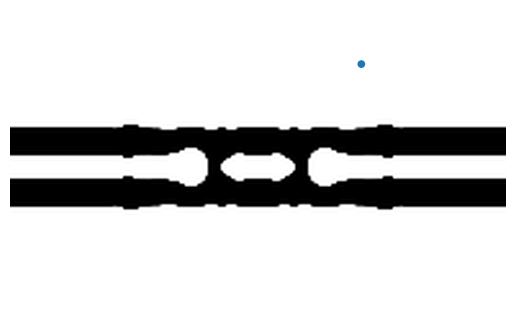

glc:, -0.002643794646755069, -0.0026930104287119123, 2.1771904187115934, 2.12797463675475
Current iteration: 115; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


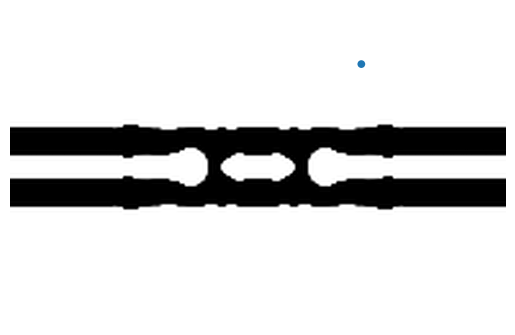

glc:, -0.0008542725714398296, -0.0008770617343088274, 2.080269192184863, 2.0574800293158653
Current iteration: 116; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


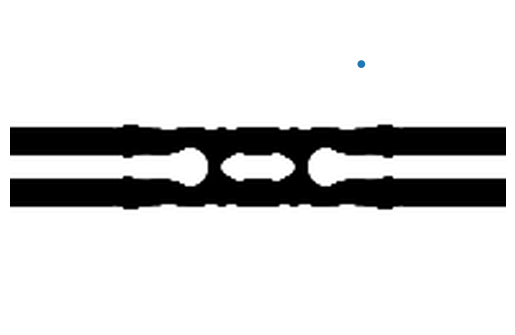

glc:, -0.00012696016310287253, -0.00012696402401407136, 2.0046305627431678, 2.004626701831969
Current iteration: 117; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


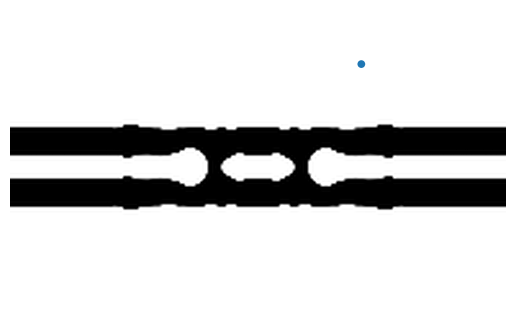

glc:, -3.039763992084628e-05, -2.567715353342403e-05, 1.947568752205147, 1.9522892385925694
Current iteration: 118; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


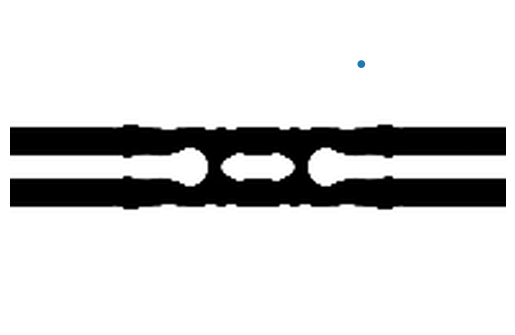

glc:, 7.441954437978392e-05, 0.00010407021288388256, 1.8987621191391983, 1.9284127876432968
Current iteration: 119; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


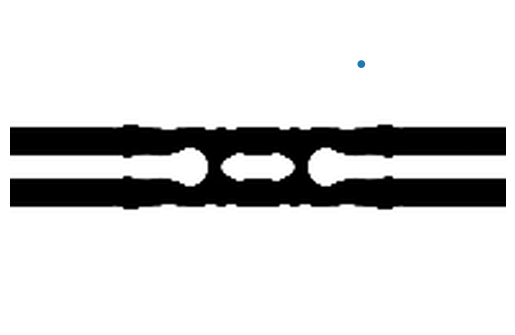

glc:, 7.441903514939603e-05, 0.00010406968652478931, 1.8987621262596017, 1.928412777634995
Current iteration: 120; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


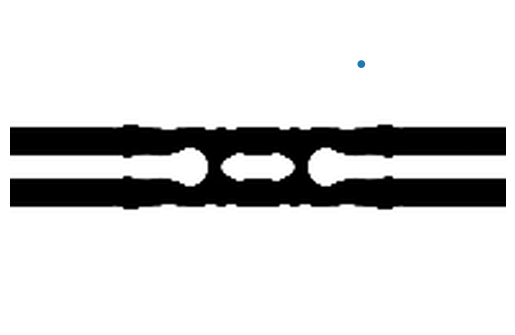

glc:, 7.441852592165511e-05, 0.00010406916016841503, 1.8987621333799751, 1.928412767626735
Current iteration: 121; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


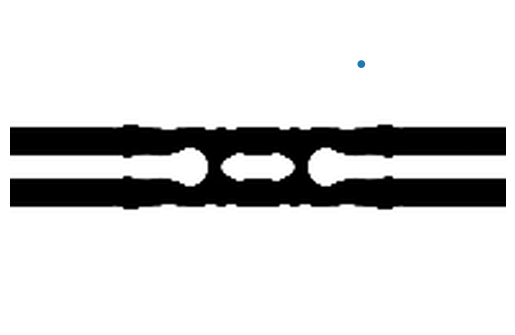

glc:, 7.441801669656051e-05, 0.00010406863381476014, 1.8987621405003188, 1.9284127576185184
Current iteration: 122; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


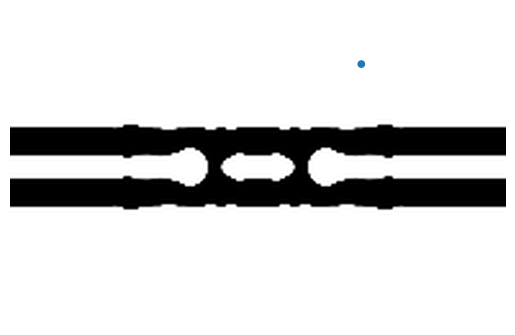

glc:, 0.00022037063363492026, 0.0002642833132264475, 1.8603611963746742, 1.9042738759662015
Current iteration: 123; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


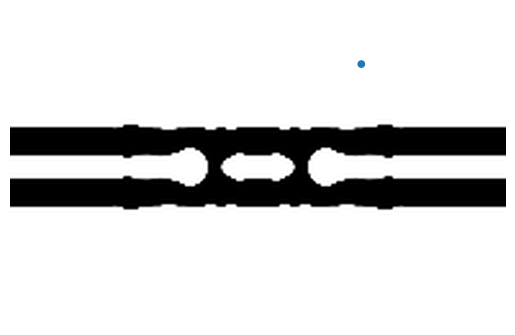

glc:, 0.0002203691654029459, 0.0002642817920191073, 1.8603612190547578, 1.9042738456709192
Current iteration: 124; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


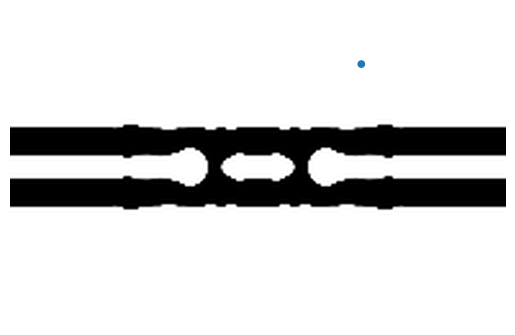

glc:, 0.00022036769718053462, 0.0002642802708216203, 1.8603612417347206, 1.9042738153758063
Current iteration: 125; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


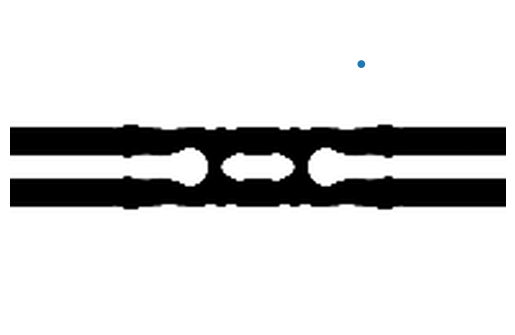

glc:, -1.759414820617358e-05, -1.825506169529645e-05, 1.8502149448124168, 1.8495540313232939
Current iteration: 126; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


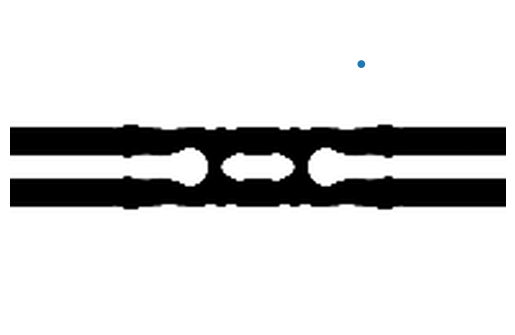

glc:, -1.7594148438114347e-05, -1.8255062002432276e-05, 1.8502149448500358, 1.849554031285718
Current iteration: 127; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


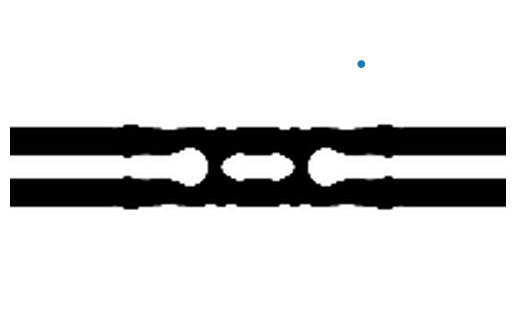

glc:, 4.399175791059773e-05, 3.7601253462803e-05, 1.8434426437708933, 1.8370521393230987
Current iteration: 128; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


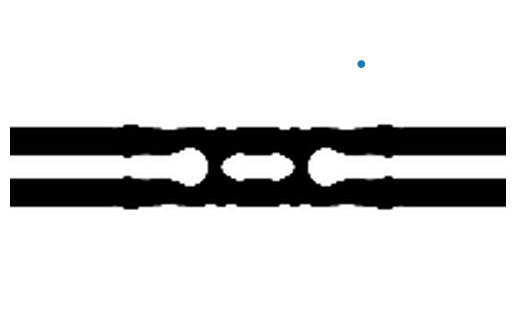

glc:, 4.399150239846306e-05, 3.7600999382133736e-05, 1.8434426430312727, 1.8370521400149435
Current iteration: 129; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


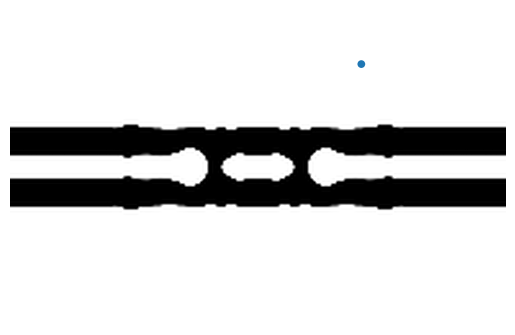

glc:, 8.363039492260646e-05, 7.081471537655464e-05, 1.8352307548128886, 1.8224150752668367
Current iteration: 130; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


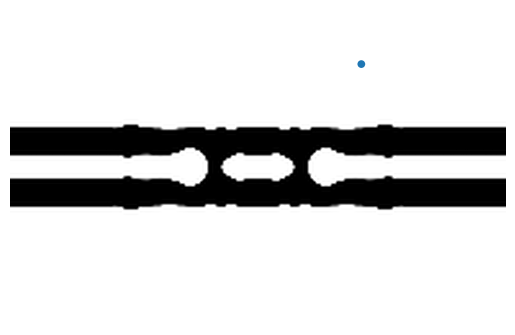

glc:, 8.363009970600182e-05, 7.081442465730475e-05, 1.8352307524036056, 1.8224150773549084
Current iteration: 131; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


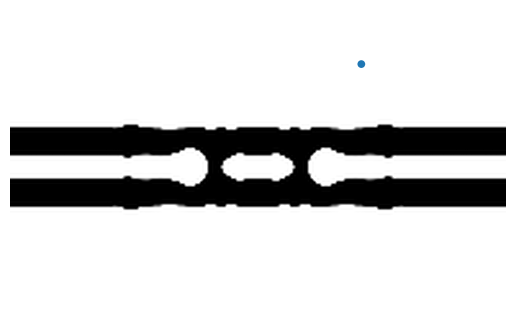

glc:, 5.2439916126939545e-05, 3.0141118440212304e-05, 1.8263714261607864, 1.8040726284740591
Current iteration: 132; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


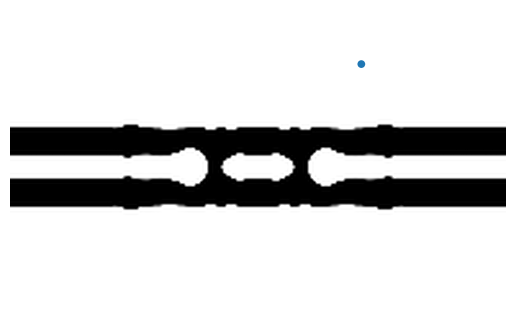

glc:, 5.243966959490019e-05, 3.0140884354266798e-05, 1.826371419306069, 1.8040726340654356
Current iteration: 133; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


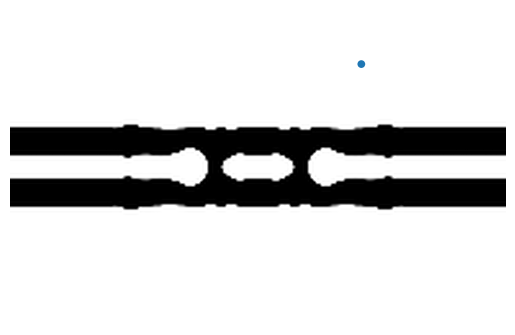

glc:, 8.001185069657509e-05, 5.377212203441545e-05, 1.8137485812950396, 1.78750885263288
Current iteration: 134; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


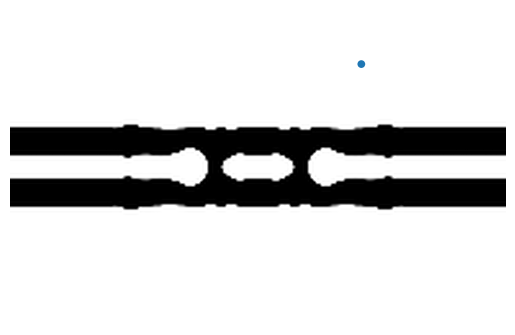

glc:, 8.001160540876181e-05, 5.3771893632953644e-05, 1.8137485714535817, 1.7875088596777735
Current iteration: 135; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


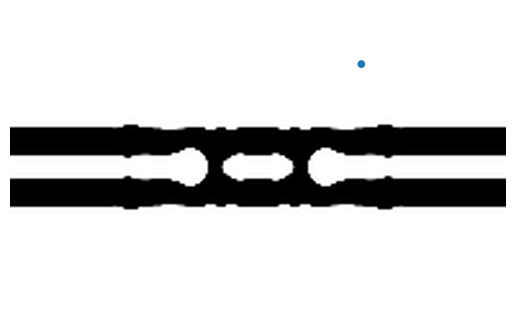

glc:, 9.494523076541473e-05, 6.538090179883252e-05, 1.800545570099377, 1.770981241132795
Current iteration: 136; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


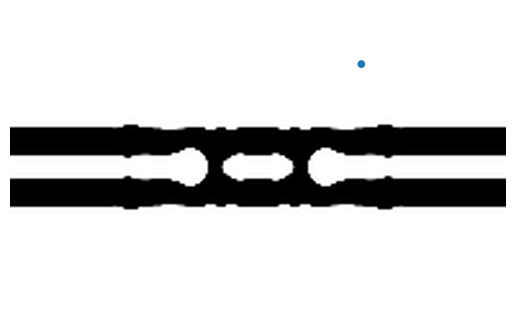

glc:, 9.494502925154664e-05, 6.538072296702812e-05, 1.8005455564773025, 1.770981250192784
Current iteration: 137; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


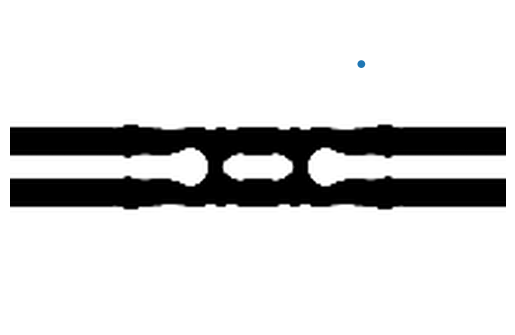

glc:, 7.263298518827904e-05, 3.354312141124025e-05, 1.7913642664565528, 1.7522744026795138
Current iteration: 138; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


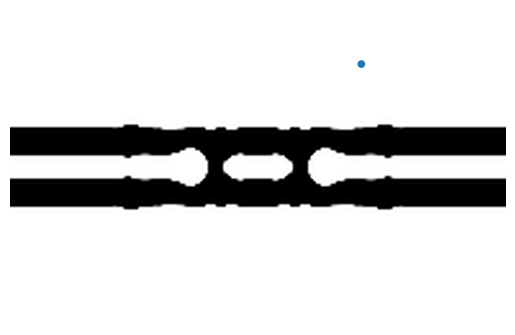

glc:, 8.556439441071394e-05, 4.416686116286844e-05, 1.7806606957371895, 1.739263162489344
Current iteration: 139; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


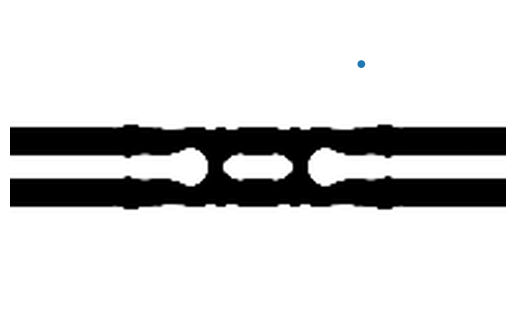

glc:, 9.136176573296649e-05, 5.433527506336919e-05, 1.7699135526589882, 1.7328870619893908
Current iteration: 140; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


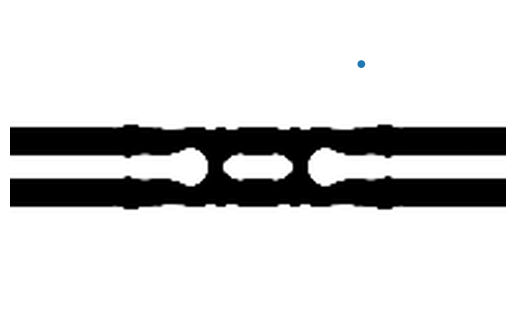

glc:, 9.136166489984382e-05, 5.4335191947870115e-05, 1.7699135412566906, 1.7328870683047168
Current iteration: 141; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


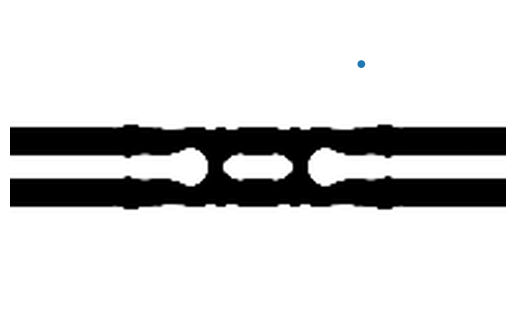

glc:, 9.136156406683695e-05, 5.4335108832466016e-05, 1.7699135298544066, 1.7328870746200358
Current iteration: 142; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


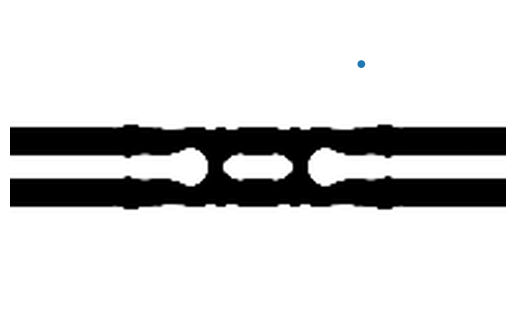

glc:, 9.136146323394652e-05, 5.433502571715581e-05, 1.769913518452138, 1.7328870809353472
Current iteration: 143; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


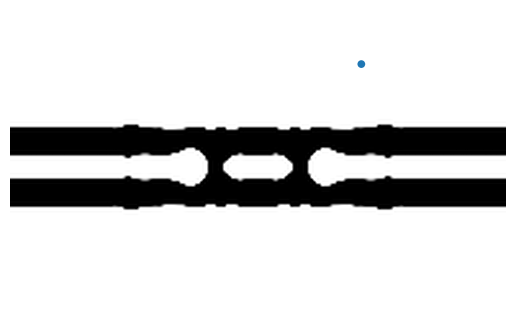

glc:, 7.521392103297902e-05, 4.218859519533862e-05, 1.7614869423039254, 1.728461616466285
Current iteration: 144; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


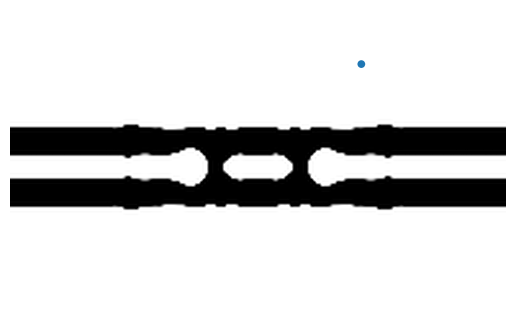

glc:, 7.5213828432123e-05, 4.218852074559798e-05, 1.7614869304603056, 1.7284616227737806
Current iteration: 145; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


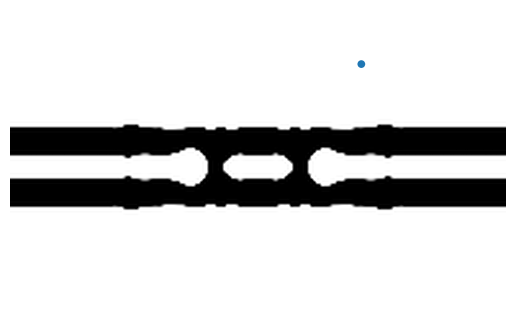

glc:, 7.521373583138842e-05, 4.21884462959547e-05, 1.7614869186167026, 1.7284616290812689
Current iteration: 146; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


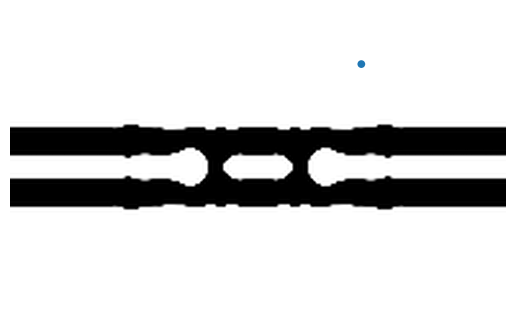

glc:, 8.033571650703053e-05, 5.3633777712367575e-05, 1.7527112935356446, 1.7260093547409816
Current iteration: 147; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


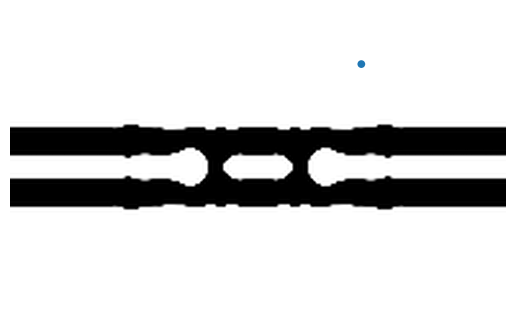

glc:, 8.033564911257484e-05, 5.3633725759553996e-05, 1.7527112835482894, 1.7260093601952686
Current iteration: 148; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


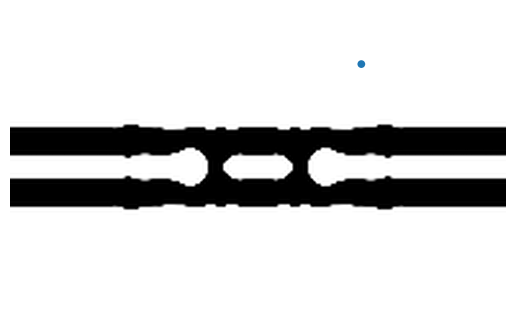

glc:, 8.03355817181879e-05, 5.363367380678769e-05, 1.7527112735609487, 1.7260093656495485
Current iteration: 149; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


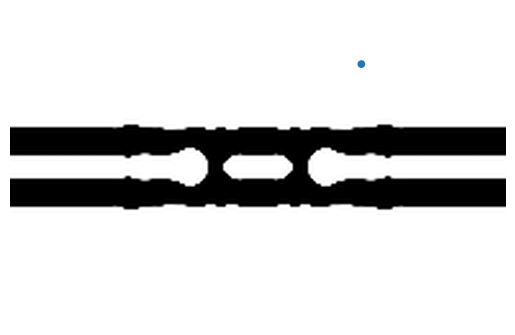

glc:, 8.473255261297764e-05, 5.832657049145099e-05, 1.7473798813736012, 1.7209738992520747
Current iteration: 150; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


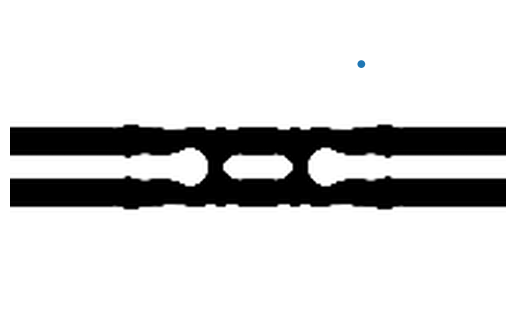

glc:, 8.74288294034182e-05, 6.079443926751155e-05, 1.750065934858214, 1.7234315447223072
Current iteration: 151; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


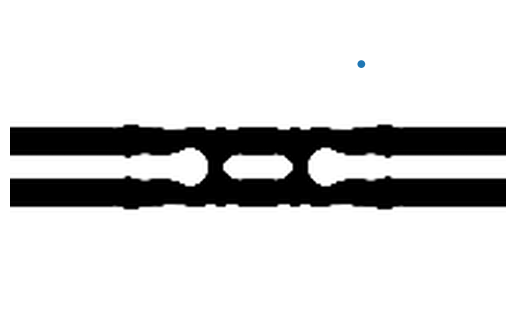

glc:, 8.74287742428613e-05, 6.079439733589929e-05, 1.7500659256381492, 1.7234315487311873
Current iteration: 152; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


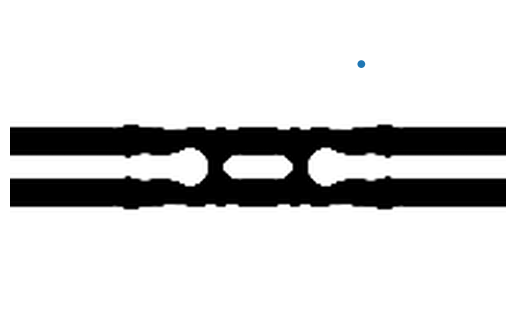

glc:, 7.434200433792306e-05, 4.823453994062311e-05, 1.7415294050354608, 1.7154219406381608
Current iteration: 153; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


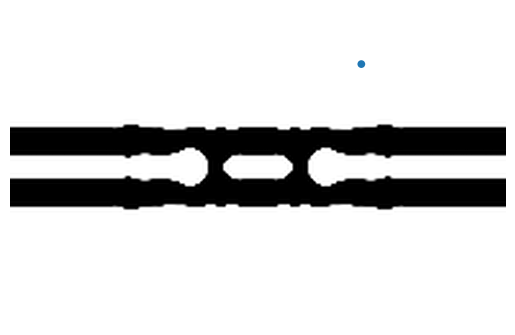

glc:, 7.858998093522801e-05, 5.184457993619965e-05, 1.7457629003692048, 1.7190174993701766
Current iteration: 154; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


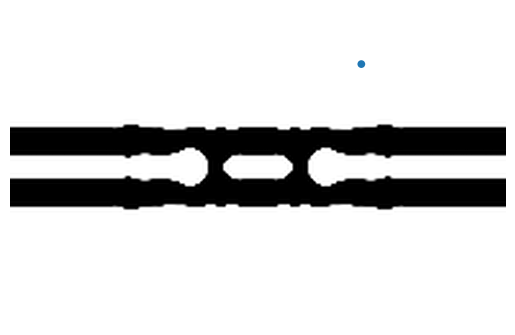

glc:, 7.858992378030399e-05, 5.18445339009934e-05, 1.7457628912417613, 1.7190175013624507
Current iteration: 155; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


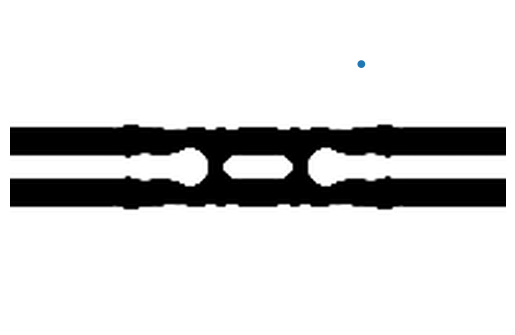

glc:, 7.169943758148184e-05, 5.341089303416316e-05, 1.7307150235681192, 1.7124264790208006
Current iteration: 156; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


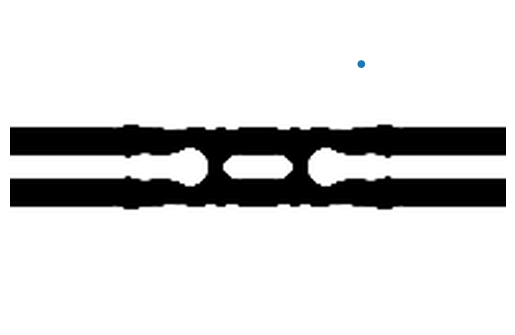

glc:, 8.036260830465215e-05, 5.498458633272315e-05, 1.739360485846258, 1.7139824638743288
Current iteration: 157; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


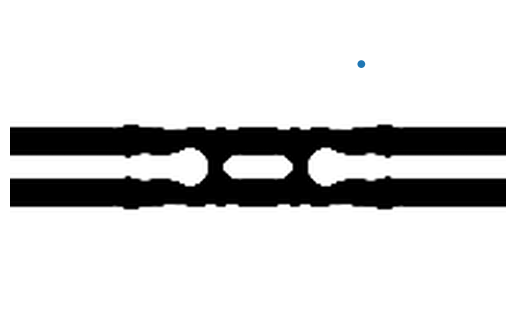

glc:, 8.154984750602997e-05, 5.5494129476078846e-05, 1.7405443603809196, 1.7144886423509684
Current iteration: 158; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


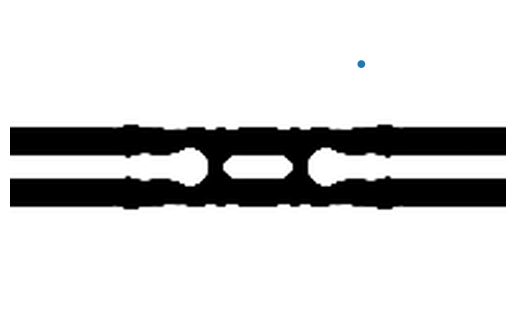

glc:, 6.524610006806834e-05, 5.96404868311467e-05, 1.7185414136766084, 1.7129358004396869
Current iteration: 159; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


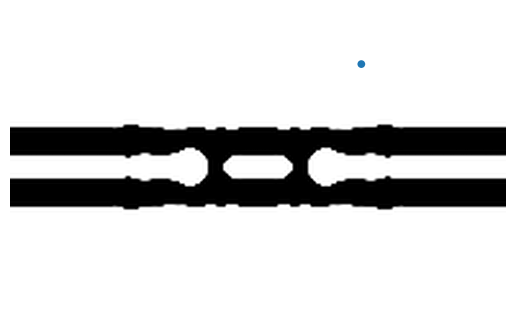

glc:, 7.487706791536484e-05, 5.749449641181286e-05, 1.728151641914847, 1.710769070411295
Current iteration: 160; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


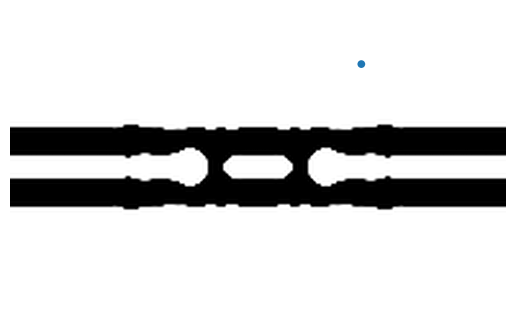

glc:, 7.487703856602092e-05, 5.749447216119399e-05, 1.728151636599529, 1.7107690701947023
Current iteration: 161; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


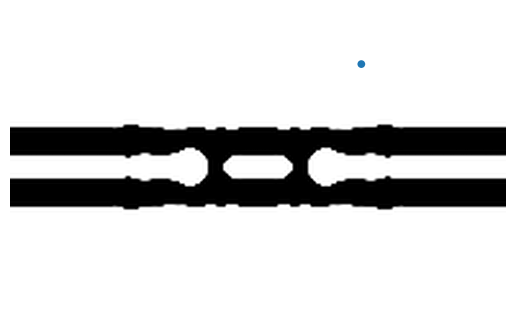

glc:, 7.487700921669739e-05, 5.749444791058726e-05, 1.7281516312842207, 1.7107690699781106
Current iteration: 162; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


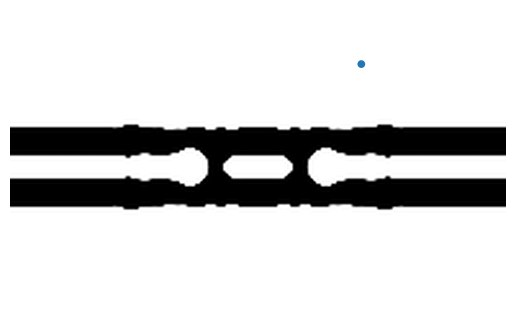

glc:, 5.756227995833878e-05, 6.266641626228491e-05, 1.7135271935560725, 1.7186313298600187
Current iteration: 163; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


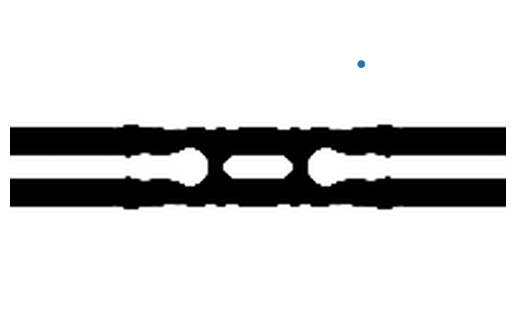

glc:, 6.554114602842429e-05, 5.9788708393468306e-05, 1.7214774967088908, 1.715725059073935
Current iteration: 164; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


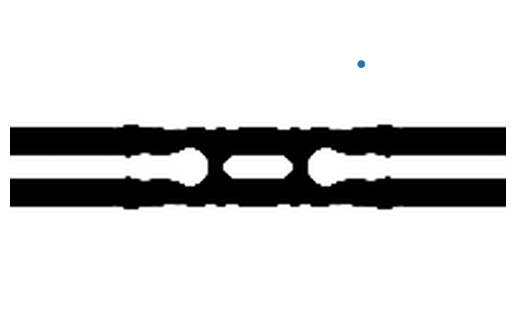

glc:, 6.554111447811136e-05, 5.978868028560396e-05, 1.7214774932027754, 1.715725059010268
Current iteration: 165; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


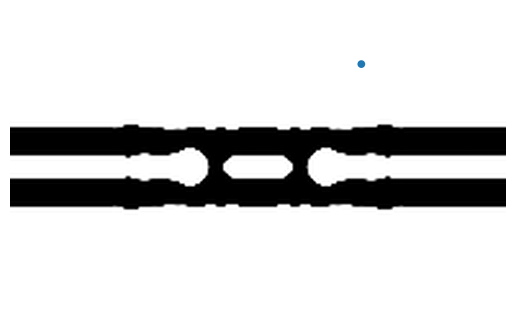

glc:, 6.463465893132578e-05, 6.810927982100578e-05, 1.7157945010190871, 1.7192691219087672
Current iteration: 166; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


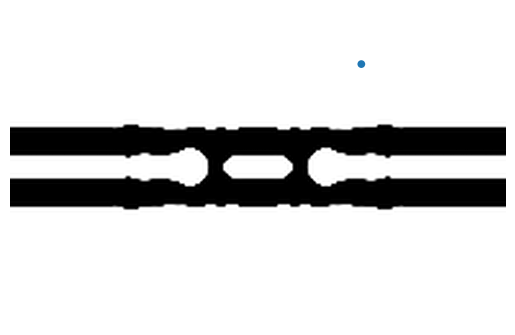

glc:, 6.63211871506789e-05, 7.073348445856302e-05, 1.7174455075050519, 1.7218578048129358
Current iteration: 167; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


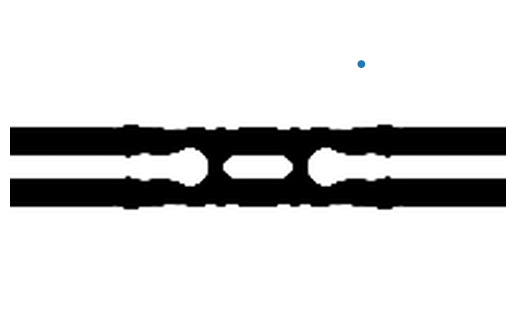

glc:, 7.004247885132836e-05, 7.280797603688395e-05, 1.7211599958170742, 1.7239254930026298
Current iteration: 168; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


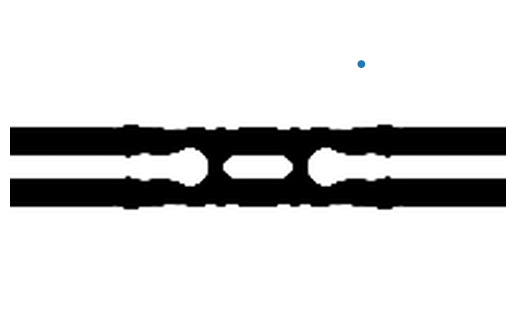

glc:, 7.004245371275051e-05, 7.280795243836693e-05, 1.7211599943140719, 1.7239254930396883
Current iteration: 169; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


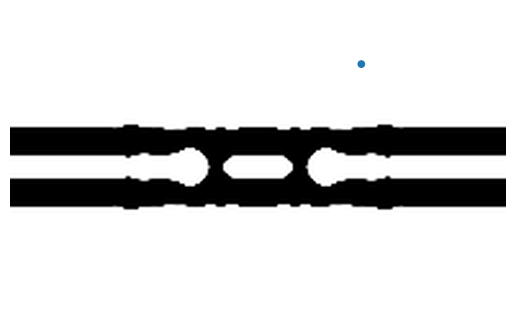

glc:, 7.646009539814943e-05, 7.589031097678892e-05, 1.7242564335001058, 1.7236866490787452
Current iteration: 170; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


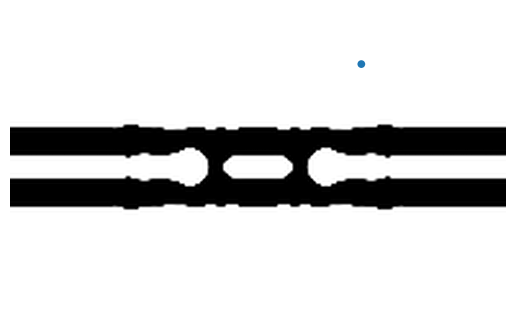

glc:, 7.600486859696254e-05, 8.732277811239128e-05, 1.723751881893135, 1.7350697914085638
Current iteration: 171; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


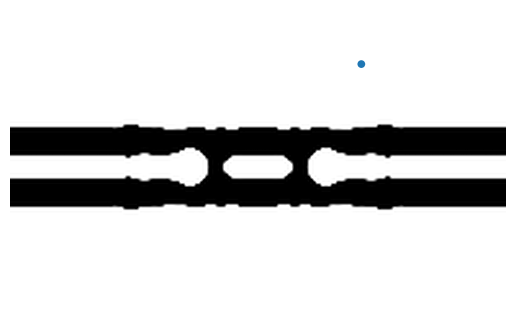

glc:, 8.456864380295315e-05, 9.448087930121938e-05, 1.73230228364372, 1.7422145191419862
Current iteration: 172; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...


In [15]:
input_flux, input_flux_data = straight_waveguide()

algorithm = nlopt.LD_MMA

n = Nx * Ny

mean = 0.0
std=0.2

# initial design parameters
x = np.ones((n,)) * 0.5 #+ np.random.normal(loc=mean, scale=std, size=(n,))


x[Si_mask.flatten()] = 1.0  # set the edges of waveguides to silicon
x[Air_mask.flatten()] = 0.0  # set the other edges to SiO2

# lower and upper bounds for design weights
lb = np.zeros((n,))
lb[Si_mask.flatten()] = 1.0
ub = np.ones((n,))
ub[Air_mask.flatten()] = 0.0

# insert epigraph variable initial value (arbitrary) and bounds into the
# design array. the actual value is determined by the objective and
# constraint functions below.
x = np.insert(x, 0, 1.2)
lb = np.insert(lb, 0, -np.inf)
ub = np.insert(ub, 0, +np.inf)

objfunc_history = []
epivar_history = []
cur_iter = [0]

beta_thresh = 32 # threshold beta above which to use subpixel smoothing
betas = [8, 16, 32]
max_evals = [50, 50, 100]
tol_epi = np.array([1e-4] * 1 * len(frequencies))  # R_top, R_bot, 1-T...1 when only trans
tol_lw = np.array([1e-8] *2 )  # line width, line spacing

input_flux, input_flux_data = straight_waveguide()

for beta, max_eval in zip(betas, max_evals):
    solver = nlopt.opt(algorithm, n + 1)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_min_objective(f)
    solver.set_maxeval(max_eval)
    solver.set_param("dual_ftol_rel", 1e-7)
    solver.add_inequality_mconstraint(
        lambda rr, xx, gg: c(
            rr,
            xx,
            gg,
            eta_i,
            beta,
            False if beta < beta_thresh else True,
            
        ),
        tol_epi,
    )


    opt = dc_optimization(
        input_flux, 
        input_flux_data,
        True,  # use_damping
        False if beta < beta_thresh else True,  # use_epsavg
        beta,
    )
    # apply the minimum linewidth constraint
    # only in the final epoch to an initial
    # binary design from the previous epoch.
    if beta == betas[-1]:
        res = np.zeros(2)
        grd = np.zeros((2, n + 1))
        t = glc(res, x, grd, beta)
        solver.add_inequality_mconstraint(
            lambda rr, xx, gg: glc(
                rr,
                xx,
                gg,
                beta,
            ),
            tol_lw,
        )

    # execute a single forward run before the start of each
    # epoch and manually set the initial epigraph variable to
    # slightly larger than the largest value of the objective
    # function over the six wavelengths and the lengthscale
    # constraint (final epoch only).
    t0,_ = opt(
        [
            mapping(
                x[1:],
                eta_i,
                beta if beta < beta_thresh else 0,
            ),
        ],
        need_gradient=False,
    )
    #t0 = np.concatenate((t0[0], t0[1], t0[2]))
    x[0] = np.amax(t0)
    x[0] = 1.05 * (max(x[0], t) if beta == betas[-1] else x[0])

    x[:] = solver.optimize(x)


In [ ]:
#################################################
#SAVE THE design_region (x)
#################################################

#np.save("design_dc_minimax_lc2.npy",x[1:])

In [ ]:
plt.matshow(x[1:].reshape(Nx,Ny))

In [ ]:
epivar_history=np.array(epivar_history)
np.save("epivar_history_lc2.npy",epivar_history)
plt.figure()
plt.plot(epivar_history,'o-')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Epivar')
plt.show()


In [ ]:
evaluation_history=np.array(evaluation_history)
np.save("evaluation_history.npy",evaluation_history)


plt.figure()
plt.plot(1-evaluation_history,'o-')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Transmitted power (Normalized)')
plt.show()


In [ ]:
'''
Insertion loss(dB) = -10 * log(P_out / P_in)   .... remember the negative sign

evaluation_history is = 1 - (P_out / P_in)

1 - evaluation_history = (P_out / P_in)

take log of this...

THE LOWER, THE BETTER


'''

lb = 1 - np.min(evaluation_history, axis=1)
ub = 1 - np.max(evaluation_history, axis=1)
mean = 1 - np.mean(evaluation_history, axis=1)

num_iters = lb.size

plt.figure()
plt.fill_between(
    np.arange(1, num_iters + 1), -10 * np.log10(lb), -10 * np.log10(ub), alpha=0.3
)
plt.plot(-10 * np.log10(mean), "o-")
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("Average Insertion Loss (dB)")
plt.show()

In [ ]:
plt.figure()
plt.plot(-10*np.log10(1-evaluation_history),'o-')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Insertion Loss (dB)')
plt.show()

In [ ]:
def dc_final_design_sim(
        final_weights: complex = x[1:].reshape(Nx,Ny),
        beta: float = 0) -> mpa.OptimizationProblem:
    """Sets up the adjoint optimization of the waveguide mode converter.

    Args:
      use_damping: whether to use the damping feature of `MaterialGrid`.
      use_epsavg: whether to use subpixel smoothing in `MaterialGrid`.

    Returns:
      A `meep.adjoint.OptimizationProblem` class object.
    """

    design_variables = mp.MaterialGrid(
        mp.Vector3(Nx,Ny),
        mp.air,
        Si,
        weights=final_weights,
        beta=beta,
    )

    design_region = mpa.DesignRegion(
        design_variables,
        volume=mp.Volume(
            center=mp.Vector3(), 
            size=mp.Vector3(design_region_length, design_region_width),
            ),
        )



    geometry = [
        mp.Block(center=mp.Vector3(x=-(design_region_length+waveguide_length)/2, y=arm_separation/2), material=Si, size=mp.Vector3(waveguide_length, waveguide_width, 0)), # top left waveguide
        mp.Block(center=mp.Vector3(x=-(design_region_length+waveguide_length)/2, y=-arm_separation/2), material=Si, size=mp.Vector3(waveguide_length, waveguide_width, 0)), # bottom left waveguide
        mp.Block(center=mp.Vector3(x=(design_region_length+waveguide_length)/2, y=arm_separation/2), material=Si, size=mp.Vector3(waveguide_length, waveguide_width, 0)), # top right waveguide
        mp.Block(center=mp.Vector3(x=(design_region_length+waveguide_length)/2, y=-arm_separation/2), material=Si, size=mp.Vector3(waveguide_length, waveguide_width, 0)), # bottom right waveguide
        mp.Block(center=design_region.center, size=design_region.size, material=design_variables)
    ]





    src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
    source = [mp.EigenModeSource(src,
                        eig_band = 1,
                        direction=mp.NO_DIRECTION,
                        eig_kpoint=kpoint,
                        size = source_size,
                        center=source_center1)]



    sim = mp.Simulation(cell_size=cell_size,
                        boundary_layers=pml_layers,
                        geometry=geometry,
                        sources=source,
                        #symmetries=[mp.Mirror(direction=mp.Y)],
                        default_material=mp.air,
                        resolution=resolution)



    mode = 1

    TE_ref = mpa.EigenmodeCoefficient(sim,
            mp.Volume(center=mp.Vector3(x=-(Sx/2 - pml_size - 0.4), y=arm_separation/2),
                size=source_size),mode, forward=False)
    TE_top = mpa.EigenmodeCoefficient(sim,
            mp.Volume(center=mp.Vector3(-(-Sx/2 + pml_size + 0.4),arm_separation/2,0),
                size=source_size),mode)
    TE_bottom = mpa.EigenmodeCoefficient(sim,
            mp.Volume(center=mp.Vector3(-(-Sx/2 + pml_size + 0.4),-arm_separation/2,0),
                size=source_size),mode)
    ob_list = [TE_ref,TE_top,TE_bottom]

    def J(source,top_output,bottom_output):
        power = npa.abs(top_output/source) **2 + npa.abs(bottom_output/source) **2
        return power

    opt = mpa.OptimizationProblem(
        simulation = sim,
        objective_functions = J,
        objective_arguments = ob_list,
        design_regions = [design_region],
        frequencies=frequencies
    )
    return opt, geometry


In [ ]:
final_sim,geometry=dc_final_design_sim(beta=betas[-1])
final_sim.plot2D(True)

In [ ]:
f0, dJ_du = final_sim([mapping(x[1:],eta_i,betas[-1])],need_gradient = False)
frequencies = final_sim.frequencies
ref_coef, top_coef, bottom_coef = final_sim.get_objective_arguments()



In [ ]:
# top_profile = np.abs(top_coef/source_coef) ** 2
# bottom_profile = np.abs(bottom_coef/source_coef) ** 2

top_profile = np.abs(top_coef) ** 2/ input_flux
bottom_profile = np.abs(bottom_coef) ** 2 / input_flux
ref_profile = np.abs(ref_coef) **2 / input_flux

In [ ]:
plt.figure()
plt.plot(1/frequencies,top_profile*100,'-o' ,label = 'Top Arm')
plt.plot(1/frequencies,bottom_profile*100,'-o',label = 'Bottom Arm')
plt.plot(1/frequencies,(ref_profile)*100,'-o',label = 'Input arm reflected')

plt.plot(1/frequencies,(top_profile + bottom_profile)*100,'-o',label = 'Net output power (%)')

plt.legend()
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Power Splitting Ratio (%)')
#plt.ylim(46.5,50)
plt.show()

In [ ]:
plt.figure()
plt.plot(1/frequencies,-10 * np.log10(top_profile + bottom_profile),'-o' ,label = 'Insertion loss')
plt.legend()
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Insertion loss (dB)')
#plt.ylim(46.5,50)
plt.show()

In [ ]:
plt.figure()
plt.plot(1/frequencies,-10 * np.log10(ref_profile),'-o' ,label = 'Return loss')
plt.legend()
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Return loss (dB)')
#plt.ylim(46.5,50)
plt.show()

In [ ]:
plt.figure()
plt.plot(1/frequencies,(np.abs(top_coef) ** 2 / np.abs(bottom_coef) ** 2) ** 2,'-o' ,label = 'Output ration')
plt.legend()
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Output power ration')
#plt.ylim(46.5,50)
plt.show()

In [ ]:
src = mp.ContinuousSource(frequency=1 / 1.55, fwidth=fwidth)
source = [
    mp.EigenModeSource(
        src,
        eig_band=1,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
        size=source_size,
        center=source_center1,
    )
]
final_sim.sim.change_sources(source)
final_sim.sim.run(until=500)
final_sim.sim.plot2D(fields=mp.Ez)

In [ ]:
sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=mp.air,
                    resolution=resolution)

In [ ]:
plt.figure(dpi=100)
sim.plot2D()
plt.show()

In [ ]:
sim.run(until=300)


In [ ]:
plt.figure(dpi=120)
sim.plot2D(fields=mp.Ez)
plt.show()

In [ ]:
sim.reset_meep()
f = plt.figure(dpi=100)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)
plt.close()

In [ ]:
sim.run(mp.at_every(1, Animate), until=150)
plt.close()

In [ ]:
filename = "dc_glc_1s.mp4"
Animate.to_mp4(10, filename)

In [ ]:
Video(filename)


In [ ]:
src = mp.ContinuousSource(frequency=1 / 1.55, fwidth=fwidth)
sources = [mp.EigenModeSource(src,
                    eig_band = 1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size = source_size,
                    center=source_center1,
                    amplitude=1.0),
            mp.EigenModeSource(
                    src,
                    eig_band=1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size=source_size,
                    center=source_center2,
                    amplitude=0.0 - 1.0j
    )]

In [ ]:
sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=mp.air,
                    resolution=resolution)

plt.figure(dpi=100)
sim.plot2D()
plt.show()

In [ ]:
sim.run(until=300)


In [ ]:
plt.figure(dpi=120)
sim.plot2D(fields=mp.Ez)
plt.show()

In [ ]:
sim.reset_meep()
f = plt.figure(dpi=100)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)
plt.close()

In [ ]:
sim.run(mp.at_every(1, Animate), until=300)
plt.close()

In [ ]:
filename = "dc_glc_2s.mp4"
Animate.to_mp4(10, filename)

In [ ]:
Video(filename)
